# MMD for two sample test

## Introduction

Throughout this file, we will deal with the problem of anomalies detection. <br>
Given a data set, the goal is to decide if each element of the data set is normal or anormal <br>
More formaly, we suppose that the normal datas are generated following a probability $p$, the observed data are generated following a probability $q$. The goal is to decide if $p=q$ or not.<br>
To answer this question we can use the $MMD_k(p,q)$.(Greton et al. 2012)<br>
$$
MMD_k(p,q) = ||\mu_p - \mu_q||^{2}_{F_k} = E_{xx'}k(x,x') + E_{yy'}k(y,y') - 2E_{xy}k(x,y)
$$
where :<br>
$k$ is a characteristic kernel<br>
$F_k$ is the Reproducing Kernel Hilbert Space associated to $k$ <br>
$\mu_p$ is the embeding of $p$ in $F_k$<br>
$x,x'$ following $p$ and $y,y'$ following $q$<br>
and $x,x',y,y'$ are independent

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
import pandas as pd
from time import time
import os
os.chdir("/home/kronert/Documents/Python/Mémoire/Memoire")
from ipywidgets import interact

In [2]:
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 8)

Populating the interactive namespace from numpy and matplotlib


/home/kronert/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Kernels

For the MMD-test we need Kernel who respect the characteristic property <br>
According to (Sriperumbudur et al. 2010) we will use the following's kernels.<br>
Gaussian kernel :
$$
k(x,y) = \exp\left(-\frac{||x-y||^{2}_{2}}{2\sigma}\right)
$$
Laplassian kernel:
$$
k(x,y) = \exp\left(-\sigma||x-y||_{1}\right)
$$

In [3]:
# Gaussian 
gaussian = lambda sigma: lambda x,y : np.exp(-np.linalg.norm(x-y,axis=1)**2/(2*sigma))
# Laplacian 
laplacian = lambda sigma: lambda x,y : np.exp(-sigma*np.linalg.norm(x-y,axis=1,ord=1))

#B2n+1-spline
#Bspline = lambda



Text(0.5, 1.0, 'Gaussian kernel')

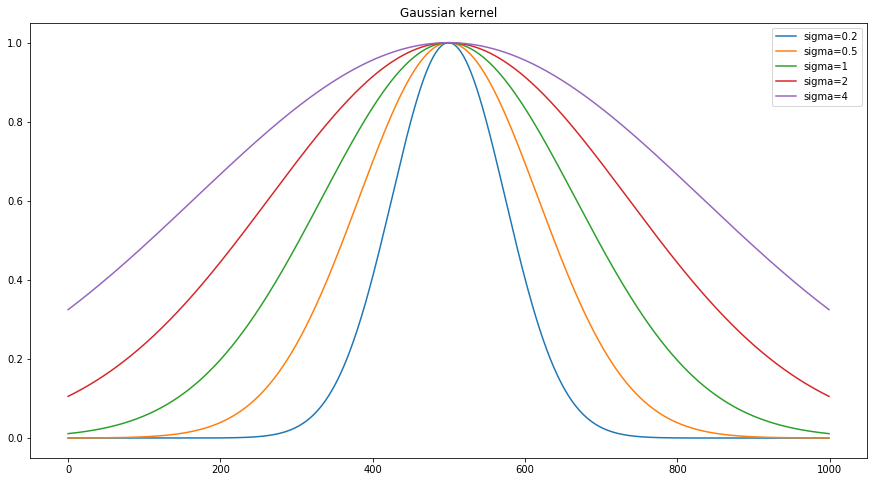

In [4]:
x = np.r_[-3:3:1000j].reshape((1000,1))
for sigma in [0.2,0.5,1,2,4]:
    plt.plot(gaussian(sigma)(x,0),label=f"sigma={sigma}")
plt.legend()
plt.title("Gaussian kernel")

Text(0.5, 1.0, 'laplacian kernel')

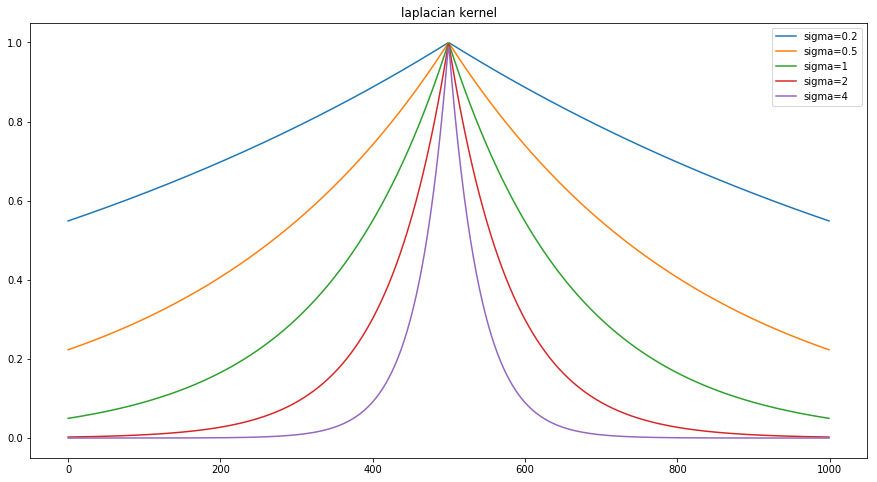

In [5]:
x = np.r_[-3:3:1000j].reshape((1000,1))
for sigma in [0.2,0.5,1,2,4]:
    plt.plot(laplacian(sigma)(x,0),label=f"sigma={sigma}")
plt.legend()
plt.title("laplacian kernel")

A convex combination of charactristic kernel is also a characteristic kernel.<br>
If $(k_i)_{1 \leq i \leq n}$ if a familly of characterisic kernels than : <br>
$$
\left\{ \sum_{0}^{n}t_ik_i~ s.a.~ \sum_{0}^{n}t_i = 1,ti\geq0 ~\forall i\right\} 
$$
Is a set of charactristics kernels.(Greton et al. 2012)




In [6]:
def CCK(kernels_list, weights_list):
    def kernel(x,y):
        res = 0
        for k,w in zip(kernels_list,weights_list):
            res += w*k(x,y)
        return res
    return  kernel

Text(0.5, 1.0, 'Convex Combination')

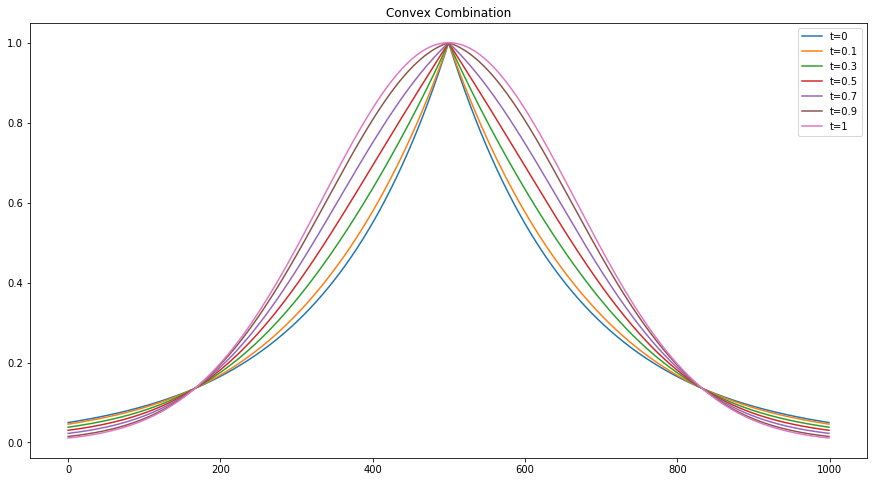

In [7]:
for t in [0,0.1,0.3,0.5,0.7,0.9,1]:
    kernel = CCK([gaussian(1),laplacian(1)],[t,1-t])
    plt.plot(kernel(x,0),label=f"t={t}")
plt.legend()
plt.title("Convex Combination")

## MMD Estimator

### Off line case

We suppose m=n <br>
There is two MMD Estimator.<br>
The MVUE estimator is the following :<br>
$$
MMD_q = \frac{1}{m(m-1)}\sum_{i\neq j}h_k(z_i,z_j) \\
h_k(z_i,z_j) = k(x_i,x_j) + k(y_i,y_j) - k(x_i,y_j) - k(y_i,x_j)
$$
However, this estimator is quadratic in time.<br>
We could also use a linear MMD Estimator
$$
MMD_l = \frac{2}{m}\sum_{i=0}^{m/2}h_k(v_i) \\
h_k(v_i) = k(x_{2i-1},x_{2i}) + k(y_{2i-1},y_{2i}) - k(x_{2i-1},y_{2i}) - k(x_{2i},y_{2i-1})
$$

#### Naive version

In the naive version, we only implement the method, explicitly with for loop

In [8]:
# Quadratic MMD
def MMDq_naive(X,Y,kernel):
    m = X.shape[0]
    n = Y.shape[0]
    res = 0
    for i in range(m):
        for j in range(m):
            if i != j:
                res += kernel(X[i].reshape((1,-1)),X[j].reshape((1,-1))) + kernel(Y[i].reshape((1,-1)),Y[j].reshape((1,-1))) - kernel(X[i].reshape((1,-1)),Y[j].reshape((1,-1))) - kernel(Y[i].reshape((1,-1)),X[j].reshape((1,-1)))
    return res/(m*(m-1))

# linear MMD     
def MMDl_naive(X,Y,kernel):
    m = X.shape[0]
    res = 0
    for i in range(0,int(m/2)):
        res += (kernel(X[2*i].reshape((1,-1)),X[2*i+1].reshape((1,-1))) 
               + kernel(Y[2*i].reshape((1,-1)),Y[2*i+1].reshape((1,-1))) 
               - kernel(X[2*i].reshape((1,-1)),Y[2*i+1].reshape((1,-1)))
               - kernel(Y[2*i].reshape((1,-1)),X[2*i+1].reshape((1,-1))))
    return 2*res/m

In [9]:
X = np.random.randn(100).reshape((100,1))
Y = np.random.randn(100).reshape((100,1))
from time import time
t = time()
print(f"La valeur de la MMDq ={MMDq_naive(X,Y,gaussian(1))}")
print(f"temps d'éxécution = {time() -t}")

La valeur de la MMDq =[0.02054334]
temps d'éxécution = 3.1151018142700195


In [10]:
t = time()
print(f"La valeur de la MMDl ={MMDl_naive(X,Y,gaussian(1))}")
print(f"temps d'éxécution = {time() -t}")

La valeur de la MMDl =[-0.06651163]
temps d'éxécution = 0.019854068756103516


As we can see, the naive method is too slow, we seek a more effective method.

#### More effective method

The following method is inspired by the MapReduce method. <br>
Fisrt, we compute all the values of $ k(x_i, x_j)$ (map). <br>
The we compute the sum (reduce).

In [11]:
def MMDq(X,Y,kernel):
    m = X.shape[0]
    res = 0
    
    X_1,X_2 = np.meshgrid(X,X)
    m_,n_ = np.meshgrid(np.arange(0,m),np.meshgrid(np.arange(0,m)))
    X_, Y_ = X_1[n_!=m_].reshape(-1,1) ,X_2[n_!=m_].reshape(-1,1)
    res += kernel(X_,Y_).sum()/(m*(m-1))
    
    X_1,X_2 = np.meshgrid(Y,Y)
    m_,n_ = np.meshgrid(np.arange(0,m),np.meshgrid(np.arange(0,m)))
    X_, Y_ = X_1[n_!=m_].reshape(-1,1) ,X_2[n_!=m_].reshape(-1,1)
    res += kernel(X_,Y_).sum()/(m*(m-1))
    
    X_1,X_2 = np.meshgrid(X,Y)
    m_,n_ = np.meshgrid(np.arange(0,m),np.meshgrid(np.arange(0,m)))
    X_, Y_ = X_1[n_!=m_].reshape(-1,1) ,X_2[n_!=m_].reshape(-1,1)
    res -= 2*kernel(X_,Y_).sum()/(m*(m-1))
    
    return res

def MMDl(X,Y,kernel):
    m = X.shape[0]
    res = 0
    
    X_, Y_ = X[0::2,:],X[1::2,:]
    res += kernel(X_,Y_).sum()
    
    
    X_, Y_ = Y[0::2,:],Y[1::2,:]
    res += kernel(X_,Y_).sum()
    
    X_, Y_ = X[0::2,:],Y[1::2,:]
    res -= kernel(X_,Y_).sum()
    
    X_, Y_ = Y[0::2,:],X[1::2,:]
    res -= kernel(X_,Y_).sum()
    
    return 2*res/m

In [12]:
from time import time
t = time()
print(f"La valeur de la MMDq ={MMDq(X,Y,gaussian(1))}")
print(f"temps d'éxécution = {time() -t}")

La valeur de la MMDq =0.020543341680929528
temps d'éxécution = 0.008631229400634766


In [13]:
t = time()
print(f"La valeur de la MMDl ={MMDl(X,Y,gaussian(1))}")
print(f"temps d'éxécution = {time() -t}")

La valeur de la MMDl =-0.06651162607512064
temps d'éxécution = 0.0010035037994384766


The second method is far more effective (20x less time), and we can check that is compute the same function.

### First Experiments

As we have, effective method to compute the MMD, we can yet compute, the MMD for some cases to make first statistics.<br>
By using the following programm's, we compute a sample for MMD.

In [14]:
dataset = pd.DataFrame(columns=["MethMMD","Kernel","size","parametre","perturbation","mmd","time"])

MethMMD = ['MMDl','MMDq']
MMD = {}
MMD['MMDl'] = MMDl
MMD['MMDq'] = MMDq

Kernel = ['gaussian','laplacian']
Ker = {}
Ker['gaussian'] = gaussian
Ker['laplacian'] = laplacian

parametre = [0.25, 0.5, 1, 2, 5]

size = [10,50,100,500,1000]

m = 100
n = 0
for i in range(m):
    for s in size:
        X = np.random.randn(s).reshape((s,1))
        Y = np.random.randn(s).reshape((s,1))
        T = np.random.uniform(low= -np.sqrt(3),high=np.sqrt(3),size=s).reshape((s,1))
        for Mmd in MethMMD:
            for kernel in Kernel:
                for p in parametre:
                   
                    
                    t = time()
                    mmd = MMD[Mmd](X,Y,Ker[kernel](p))
                    t = time() - t
                    dataset.loc[n] = [Mmd, kernel,p,'same',s,mmd,t]
                    n+=1
                    
                    t = time()
                    mmd = MMD[Mmd](X,Y+1,Ker[kernel](p))
                    t = time() - t
                    dataset.loc[n] = [Mmd, kernel,p,'mu+1',s,mmd,t]
                    n+=1
                    
                    t = time()
                    mmd = MMD[Mmd](X,Y*2,Ker[kernel](p))
                    t = time() - t
                    dataset.loc[n] = [Mmd, kernel,p,'std*2',s,mmd,t]
                    n+=1
                    
                    t = time()
                    mmd = MMD[Mmd](X,T,Ker[kernel](p))
                    t = time() - t
                    dataset.loc[n] = [Mmd, kernel,p,'unif_law',s,mmd,t]
                    n+=1
        print(s)
    print(i)

dataset.to_csv("MMD_data.csv", encoding='utf-8', index=False)  

10
50
100


KeyboardInterrupt: 

We get the saving data

In [14]:
#dataset.to_csv("MMD_data.csv", encoding='utf-8', index=False)  
data_experiment = pd.read_csv('MMD_data.csv')

### Explore the Data

In [15]:
data_experiment.head()

,MethMMD,Kernel,parametre,perturbation,size,mmd,time
0,MMDl,gaussian,0.25,same,10,0.334307,0.000538
1,MMDl,gaussian,0.25,mu+1,10,0.512887,0.000473
2,MMDl,gaussian,0.25,std*2,10,0.202952,0.000503
3,MMDl,gaussian,0.25,unif_law,10,0.308257,0.000771
4,MMDl,gaussian,0.50,same,10,0.312142,0.000452


In [16]:
data_experiment.describe()

,parametre,size,mmd,time
count,40000.000000,40000.000000,40000.000000,40000.000000
mean,1.750000,332.000000,0.047192,0.033147
std,1.732072,377.226136,0.100523,0.081201
min,0.250000,10.000000,-0.734751,-0.777871
25%,0.500000,50.000000,-0.000586,0.000535
50%,1.000000,100.000000,0.029843,0.001447
75%,2.000000,500.000000,0.094236,0.003823
max,5.000000,1000.000000,0.967662,0.905150


#### Complexity in time

In [17]:
@interact(methode=["MMDq","MMDl"])
def complexity(methode):
    return sea.lineplot(x='size',y='time',data=data_experiment[data_experiment['MethMMD']==methode])

interactive(children=(Dropdown(description='methode', options=('MMDq', 'MMDl'), value='MMDq'), Output()), _dom…

#### Distribution

In [18]:
@interact(methode=["MMDq","MMDl"],perturbation=["same","mu+1","std*2","unif_law"],kernel=["gaussian","laplacian"],
          size=[10,50,100,500,1000],parametre=[0.25, 0.5, 1, 2, 5])
def complexity(methode,perturbation,kernel,size,parametre):
    return sea.kdeplot(data=data_experiment[data_experiment['MethMMD']==methode][data_experiment['size']==size][data_experiment['Kernel']==kernel][data_experiment['perturbation']==perturbation][data_experiment['parametre']==parametre]['mmd'])

interactive(children=(Dropdown(description='methode', options=('MMDq', 'MMDl'), value='MMDq'), Dropdown(descri…

#### Separation

In [19]:
@interact(methode=["MMDq","MMDl"],kernel=["gaussian","laplacian"],parametre=[0.25, 0.5, 1, 2, 5])
def complexity(methode,kernel,parametre):
    return sea.lineplot(x='size',y='mmd',data=data_experiment[data_experiment['MethMMD']==methode][data_experiment['Kernel']==kernel][data_experiment['parametre']==parametre],hue="perturbation")

interactive(children=(Dropdown(description='methode', options=('MMDq', 'MMDl'), value='MMDq'), Dropdown(descri…

In [20]:
@interact(methode=["MMDq","MMDl"],kernel=["gaussian","laplacian"],parametre=[0.25, 0.5, 1, 2, 5],q=["mu+1","std*2","unif_law"],size=50)
def complexity(methode,kernel,parametre,q,size):
    return sea.violinplot(x='size',y='mmd',data=pd.concat([data_experiment[data_experiment['perturbation']==q],data_experiment[data_experiment['perturbation']=="same"]])[data_experiment['MethMMD']==methode][data_experiment['Kernel']==kernel][data_experiment['size']>=size],hue="perturbation",split=True)

interactive(children=(Dropdown(description='methode', options=('MMDq', 'MMDl'), value='MMDq'), Dropdown(descri…

### Treshold Estimator

For the treshold estimator base on condition that error A should arrive with probability of 5%.<br>
We build an estimator of the 95th centile, with bootstrap method, with $H_0$ hypotesis.

In [28]:
def treshold_estimator(X,MMD,m, nb_turn = 100):
    mmd_list = []
    for i in range(nb_turn):
        x = np.random.choice(X, size = m, replace=True)
        y = np.random.choice(X, size = m, replace=True)
        mmd_list.append(abs(MMD(x.reshape((m,-1)),y.reshape((m,-1)))))
    mmd_list.sort()
    return mmd_list[int(95*nb_turn/100)]

In [22]:
X = np.random.randn(1000)
treshold_estimator(X,lambda x,y : MMDl(x,y,gaussian(0.25)),100,nb_turn=10000)

0.18063946634744696

#### Linear MMD case

By using that $m^{1/2}(MMDl - MMD(p,q)) \rightarrow N(0,2\sigma)$ in law in the case of $H_0$ hypotesis.<br>
$ t_{\alpha} = m^{-1/2}\sigma\sqrt{2} \Phi^{-1}(1-\alpha)$ where $\sigma$ is the standart deviation of $h$.<br>
(Gretton et al., 2012)
When $\alpha = 0.05$ then $\Phi^{-1}(1-\alpha) = 1.64$

In [23]:
def h_std_estimator(X,kernel, nb_turn = 100):
    x = X[:X.shape[0]//2,:]
    y = X[X.shape[0]//2:,:]
    indices = np.arange(0,X.shape[0]//2,2)
    h_list = []
    for _ in range(nb_turn):
        i = np.random.choice(indices, size = 1, replace=True)
        h_list.append(kernel(x[i],x[i+1]) + kernel(y[i],y[i+1]) - kernel(y[i],x[i+1]) - kernel(x[i],y[i+1]))
    return np.std(h_list)

In [24]:
X = np.random.randn(1000).reshape((1000,1))
h_std_estimator(X,gaussian(0.25),nb_turn=10000)*1.14*1.64/(100)**0.5


0.11533025176581375

### Experience Off line

In this experience, we have n sample from p law and n sample from q law. <br>
The goal is to see if we can _ anormals values acoording to our treshold

In [25]:
X = np.random.randn(1000)
size = [10,50,100,500,1000]
MMDdict = {}
MMDdict['MMDl'] = MMDl
MMDdict['MMDq'] = MMDq

Ker = {}
Ker['gaussian'] = gaussian
Ker['laplacian'] = laplacian

@interact(methode=["MMDl","MMDq"],kernel=["gaussian","laplacian"],parametre=[5, 0.5, 1, 2, 0.25])
def complexity(methode,kernel,parametre):
    L = []
    M = []
    MMD = lambda x,y : MMDdict[methode](x,y,Ker[kernel](parametre))
    for s in size:
        L.append(treshold_estimator(X,MMD,s, nb_turn = 100))
        M.append(h_std_estimator(X.reshape((1000,1)),Ker[kernel](parametre), nb_turn = 100)*1.14*1.64/(s)**0.5)
    
    
    
    plt.plot(size, L, 'k-',label="95%_treshold")
    plt.plot(size, M, 'y-',label="std_threshold")

    return sea.lineplot(x='size',y='mmd',data=data_experiment[data_experiment['MethMMD']==methode][data_experiment['Kernel']==kernel],hue="perturbation")

interactive(children=(Dropdown(description='methode', options=('MMDl', 'MMDq'), value='MMDl'), Dropdown(descri…

We can see that :<br>
    - if we increase the parameter of a gaussian, it is easier to separate<br>
    - We need around 200 to make good prediction <br>
    - MMDq perform better<br>
    - a modification in law seem harder than modification in moments

# On line experiment

In this experience, we suppose to have sequential data. The first 1000 samples represent the normal data. We use this data as a reference when compute the MMD.<br>
Then the 1000 next are data who arrive one by one during a period of time.<br>
At each timestep, we can compute a MMDl.<br>
For the experience, we add an anormality during the processus.<br>
The goal is to detect this anormality.


#### Mean modification - linear MMD

0.055793435451926

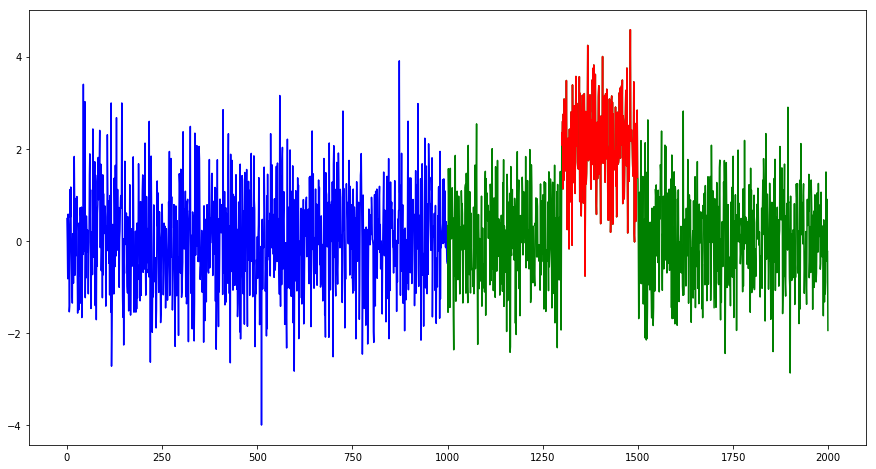

In [26]:
X = np.random.randn(1000).reshape((1000,1))
Y = np.random.randn(1000).reshape((1000,1))
Y[300:500] += 2
plt.plot(range(1000),X,'b')
plt.plot(range(1000,2000),Y,'g')
plt.plot(range(1300,1500),Y[300:500],'r')
treshold_estimator(X.reshape(1000),lambda x,y: MMDl(x,y,gaussian(5)),100, nb_turn = 100)

In this graph, the reference data set is blue, the anormal data are red.

In [27]:
MMDdict = {}
MMDdict['MMDl'] = MMDl
MMDdict['MMDq'] = MMDq

Ker = {}
Ker['gaussian'] = gaussian
Ker['laplacian'] = laplacian


@interact(methode=["MMDl","MMDq"],kernel=["gaussian","laplacian"],
          parametre=[0.25, 0.5, 1, 2, 5,10],size=[10,20,50,100],
          step=[10,20,50,100],repeat=[1,10,100])
def on_line_test(methode,kernel,parametre,size,step,repeat):
    data = pd.DataFrame(columns=["i","mmd"])
    
    n = 0
    L = []
    for _ in range(repeat):
        X = np.random.randn(1000).reshape((1000,1))
        Y = np.random.randn(1000).reshape((1000,1))
        Y[300:500] += 2
        for i in range(0,1000,step):
            if (i+size<1000):
                data.loc[n] = [i,MMDdict[methode](X[:size],Y[i:i+size],Ker[kernel](parametre))]
                n += 1
    t=treshold_estimator(X.reshape(1000),
                         lambda x,y:MMDdict[methode](x,y,Ker[kernel](parametre)),
                         size, nb_turn = 100)
    sig = h_std_estimator(X.reshape((1000,1)),Ker[kernel](parametre), nb_turn = 100)*1.14*1.64/(size)**0.5
    sea.lineplot(data=data,x='i',y='mmd')
    plt.plot(np.ones(1000)*t,label="95%")
    plt.plot(np.ones(1000)*sig,label="sigma")
    plt.legend()

interactive(children=(Dropdown(description='methode', options=('MMDl', 'MMDq'), value='MMDl'), Dropdown(descri…

We can see that, by increasing the gaussian's parameter we detect the anormality.<br> 
But if this parameter is too big, we have a lot of false positiv.<br>
We can have good result in few amont of time and with fine granularity.

# Linear Estimator in case m!=n

The previous linear estimator has good property. But it work only if the number of data in X and in Y are the same.<br>
This is often a problem in on-line framework, as we become the data one by one.<br>
We will study the properies of an extention of the linear MMD.

$$MMD_{2l}(p,q) = \frac{2}{m}\sum k(x_{2i},x_{2i-1}) +  \frac{2}{n}\sum k(y_{2i},y_{2i-1}) -2 \frac{1}{m}\sum\frac{1}{n}\sum k(x_i,y_j)$$

Naively, we could implement the MMD2l estimator like the following way:

In [28]:
def MMD2l_naive(X,Y,kernel):
    m = X.shape[0]
    n = Y.shape[0]
    res = 0
    
    # The two first terms can be computed easely
    res += 2/m*kernel(X[0::2],X[1::2]).sum()
    res += 2/n*kernel(Y[0::2],Y[1::2]).sum()
    
    sum_ = 0
    # We compute the double sum with a double for-loop
    for i in range(m):
        print(i, end='\r', flush=True)
        for j in range(n):
            sum_ += kernel(X[i].reshape((1,1)),Y[j].reshape((1,1)))
    return res -2/(n*m)*sum_

In [29]:
%%time
X = np.random.randn(1000).reshape((1000,1))
Y = np.random.randn(1000).reshape((1000,1))
print(MMD2l_naive(X,Y,gaussian(0.25)))

[-0.03091603]
CPU times: user 1min 37s, sys: 1.87 s, total: 1min 39s
Wall time: 1min 38s


But this method has two issues : <br>
    - It's quadratic in time and then to effective
    - it is not suitable for online case

To solve this troubles, we use a sequential implementation for the linear-extended MMD estimator. 

$$ MMD_{l}(p,q)_{m,n} = Estimnorm(p)_m + \frac{2}{n}Sumnorm(q)_{n} -2+ \frac{2}{nm} SumPS(p,q)_{m,n}$$
Algorithm sequential MMDl: <br>
Init : 
$$Estimnorm(p)_m = \frac{2}{m}\sum k(x_{2i},x_{2i-1})$$
$$Sumnorm(q)_0 = 0$$
$$SumPS(p,q)_{m,0} = 0$$
Update : 
$$Sumnorm(q)_{n+2} = Sumnorm(q)_{n} + k(y_{n},y_{n-1})$$
$$SumPS(p,q)_{m,n+2} = SumPS(p,q)_{m,n} + \sum k(x_i,y_n) + k(x_i,y_{n-1})$$


In [15]:
class MMD2l():
    def __init__(self,X,kernel):
        self.X = X
        self.Y = []
        self.m = X.shape[0]
        self.n = 0
        self.kernel = kernel
        
        X_, Y_ = X[0::2,:],X[1::2,:]
        self.estim_normP = 2/self.m*self.kernel(X_,Y_).sum()
        
        self.sumNormQ = 0
        self.sumPS = 0
        
        self.MMD = self.estim_normP 
        
    #def treshold(self):
        
    
    def update(self,y1,y2):
        self.sumNormQ += self.kernel(y1,y2)
        
        self.sumPS += self.kernel(X,y1).sum() + self.kernel(X,y2).sum()
        
        self.n += 2
        
        self.MMD = self.estim_normP + 2/self.n * self.sumNormQ - 2/(self.n*self.m)*self.sumPS
        
   # def check(self):

In [15]:
%%time
MMD = MMD2l(X,gaussian(0.25))
for i in range(500):
    MMD.update(Y[2*i].reshape(1,1),Y[2*i+1].reshape(1,1))
print(MMD.MMD[0])

IndexError: index 100 is out of bounds for axis 0 with size 100

As expected, the two implementations give the same result but the second is far more efficient.

# Study of the asymptotic law of MMD2l

To have a statistical test, we have to know the law of MMD2l under the hypothesis H0.<br>
To do so, we search the asymptotic law.<br>
Because of the Central Limit Theorem, we expext to have an gaussian law.<br>
Because the estimator is unbiaised, we know that the mean of this law is MMD (0 in H0 Hypothesis).

## Mathematical Approach

We want to have strong result so we will prove the result mathematically.<br>
The in a second time we will verified it's work with simulations.

### Mercer's Kernel Approximation

First, we suppose that $k$ is a Mercer kernel, so there exist an Hilbert Base $(\phi_l)_l$ and a sequence $(\mu_l)_l$ such that:<br>
$\forall (x,y) k(x,y) = \sum_l \mu_l \phi_l(x)\phi_l(y) $<br>
so<br>
$$MMD(X,Y) = \frac{2}{m}\sum_i k(x_{2i-1},x_{2i}) + \frac{2}{n}\sum_j k(y_{2j-1},y_{2j}) - \frac{2}{mn}\sum_{j,i}k(x_{i},y_{j})$$
became<br>
$$MMD(X,Y) = \sum_l \mu_l\left(\frac{2}{m}\sum_i \phi_l(x_{2i-1})\phi_l(x_{2i}) + \frac{2}{n}\sum_j \phi_l(y_{2j-1})\phi_l(y_{2j}) - \frac{2}{mn}\sum_{j,i} \phi_l(x_{i})\phi_l(y_{j})\right)$$
for the same reasons <br>
$$MMD(p,q) = E(k(X,X')) + E(k(Y,Y')) -2 E(k(X,Y))$$
become <br>
$$MMD(p,q) = \sum_l \mu_l\left(E(\phi_l(X)\phi_l(X')) + E(\phi_l(Y)\phi_l(Y')) -2 E(\phi_l(X)\phi_l(Y))\right)$$
with independency
$$MMD(p,q) = \sum_l \mu_l\left(E(\phi_l(X))^2 + E(\phi_l(Y))^2 -2 E(\phi_l(X))E(\phi_l(Y))\right)$$
yet we have <br>
$$ MMD(X,Y) - MMD(p,q) = 
\sum_l \mu_l\left(
\frac{2}{m}\sum_i \phi_l(x_{2i-1})\phi_l(x_{2i}) - E(\phi_l(X))^2 
+ \frac{2}{n}\sum_j \phi_l(y_{2j-1})\phi_l(y_{2j}) - E(\phi_l(Y))^2 
- \frac{2}{mn}\sum_{j,i} \phi_l(x_{i})\phi_l(y_{j}) - E(\phi_l(X))E(\phi_l(Y))
\right)$$

We will yet studying more precisely the third term of the sum :
$$\phi_l(x_{i})\phi_l(y_{j}) - E(\phi_l(X))E(\phi_l(Y)) = \phi_l(x_{i})\left[\phi_l(y_{j}) - E(\phi_l(Y))\right] + \phi_l(x_{i})E(\phi_l(Y)) - E(\phi_l(X))E(\phi_l(Y))$$
$$\phi_l(x_{i})\phi_l(y_{j}) - E(\phi_l(X))E(\phi_l(Y)) = \phi_l(x_{i}) \left[\phi_l(y_{j}) - E(\phi_l(Y))\right] + \left[\phi_l(x_{i}) - E(\phi_l(X))\right]E(\phi_l(Y))$$
$$\phi_l(x_{i})\phi_l(y_{j}) - E(\phi_l(X))E(\phi_l(Y)) = 
\left[\phi_l(x_{i}) - E(\phi_l(X))\right]\left[\phi_l(y_{j}) - E(\phi_l(Y))\right]
+ E(\phi_l(X))\left[\phi_l(y_{j}) - E(\phi_l(Y))\right]
+ \left[\phi_l(x_{i}) - E(\phi_l(X))\right]E(\phi_l(Y))$$

by using the same transformations, we have :
$$ \phi_l(x_{2i-1})\phi_l(x_{2i}) - E(\phi_l(X))^2  = 
\left[\phi_l(x_{2i-1}) - E(\phi_l(X))\right]\left[\phi_l(x_{2i}) - E(\phi_l(X))\right]
+ E(\phi_l(X))\left[\phi_l(x_{2i}) - E(\phi_l(X))\right]
+ \left[\phi_l(x_{2i-1}) - E(\phi_l(X))\right]E(\phi_l(X))$$
And :<br>
$$ \phi_l(y_{2j-1})\phi_l(y_{2j}) - E(\phi_l(Y))^2  = 
\left[\phi_l(y_{2j-1}) - E(\phi_l(Y))\right]\left[\phi_l(x_{2j}) - E(\phi_l(Y))\right]
+ E(\phi_l(Y))\left[\phi_l(y_{2j}) - E(\phi_l(Y))\right]
+ \left[\phi_l(y_{2j-1}) - E(\phi_l(Y))\right]E(\phi_l(Y))$$

We can see that : <br>
$$\frac{2}{mn}\sum_{i,j} E(\phi_l(X))\left[\phi_l(y_{j}) - E(\phi_l(Y))\right]
= \frac{2}{n}\sum_{j} E(\phi_l(X))\left[\phi_l(y_{j}) - E(\phi_l(Y))\right]$$
$$\sum_i E(\phi_l(X))\left[\phi_l(x_{2i}) - E(\phi_l(X))\right]
+ \left[\phi_l(x_{2i-1}) - E(\phi_l(X))\right]E(\phi_l(X)) 
= \sum_i E(\phi_l(X))\left[\phi_l(x_{i}) - E(\phi_l(X))\right]$$
And in H0 Hypotethis <br>
$$E(X) = E(Y)$$

That give us : <br>
$$ MMD(X,Y) - MMD(p,q) =  
\sum_l \mu_l\left(
\frac{2}{m}\sum_i \left[\phi_l(x_{2i-1}) - E(\phi_l(X))\right]\left[\phi_l(x_{2i}) - E(\phi_l(X))\right]
+ \frac{2}{n}\sum_j \left[\phi_l(y_{2j-1}) - E(\phi_l(Y))\right]\left[\phi_l(x_{2j}) - E(\phi_l(Y))\right]
- \frac{2}{mn}\sum_{j,i} \left[\phi_l(x_{i}) - E(\phi_l(X))\right]\left[\phi_l(y_{j}) - E(\phi_l(Y))\right]
\right)$$
$$ MMD(X,Y) - MMD(p,q) =
\frac{2}{m}\sum_i \left\{
\sum_l \mu_l 
\phi_l(x_{2i-1})\phi_l(x_{2i}) 
-E\left[\sum_l \mu_l 
\phi_l(X)\phi_l(x_{2i})\right] 
-E\left[\sum_l \mu_l 
\phi_l(x_{2i-1})\phi_l(X)\right]
+E\left[\sum_l \mu_l 
\phi_l(X)\phi_l(X')\right]
\right\}
+
\frac{2}{n}\sum_j \left\{
\sum_l \mu_l 
\phi_l(y_{2j-1})\phi_l(y_{2j}) 
-E\left[\sum_l \mu_l 
\phi_l(Y)\phi_l(y_{2j})\right] 
-E\left[\sum_l \mu_l 
\phi_l(y_{2j-1})\phi_l(Y)\right]
+E\left[\sum_l \mu_l 
\phi_l(Y)\phi_l(Y')\right]
\right\}
- 
\frac{2}{nm}\sum_{i,j} \left\{
\sum_l \mu_l 
\phi_l(x_{i})\phi_l(y_{j}) 
-E\left[\sum_l \mu_l 
\phi_l(X)\phi_l(y_{j})\right] 
-E\left[\sum_l \mu_l 
\phi_l(x_{i})\phi_l(Y)\right]
+E\left[\sum_l \mu_l 
\phi_l(X)\phi_l(Y)\right]
\right\}
$$

$$ MMD(X,Y) - MMD(p,q) =
\frac{2}{m}\sum_i 
k(x_{2i-1},x_{2i}) -k(.,x_{2i}) -k(x_{2i-1},.)  + k(.,.)
+
\frac{2}{n}\sum_j 
k(y_{2j-1},y_{2j}) -k(.,y_{2j}) -k(y_{2j-1},.)  + k(.,.)
- 
\frac{2}{nm}\sum_{i,j} 
k(x_{i},y_{j}) -k(.,y_{j}) -k(x_{i},.)  + k(.,.)
$$
with $k(x,.) = E(k(x,X))$


### A more General Case

To deal with a more general case, we use : $k(x,y) = <\xi_x,\xi_y> $ (Fubinni, hypotethis 1)<br>
Then because the scalar product is bilinear, we can use the same tricks than in the Mercer case.
So :
$$ MMD(X,Y) - MMD(p,q) = 
\frac{2}{m}\sum_i <\xi_{x_{2i}},\xi_{x_{2i-1}}> - <E\xi_x,E\xi_x>
+ \frac{2}{n}\sum_j <\xi_{y_{2j}},\xi_{y_{2j-1}}> - <E\xi_y,E\xi_y>
- \frac{2}{mn}\sum_{j,i}  <\xi_{x_{i}},\xi_{y_{j}}> - <E\xi_x,E\xi_y>
$$
$$ MMD(X,Y) - MMD(p,q) = 
\frac{2}{m}\sum_i <\xi_{x_{2i}} - E\xi_x,\xi_{x_{2i-1}} - E\xi_x> 
+ \frac{2}{n}\sum_j <\xi_{y_{2j}} - E\xi_y,\xi_{y_{2j-1}} - E\xi_y> 
- \frac{2}{mn}\sum_{j,i}  <\xi_{x_{i}} - E\xi_x, \xi_{y_{j}} - E\xi_y> 
$$
$$ MMD(X,Y) - MMD(p,q) =
\frac{2}{m}\sum_i 
k(x_{2i-1},x_{2i}) -k(.,x_{2i}) -k(x_{2i-1},.)  + k(.,.)
+
\frac{2}{n}\sum_j 
k(y_{2j-1},y_{2j}) -k(.,y_{2j}) -k(y_{2j-1},.)  + k(.,.)
- 
\frac{2}{nm}\sum_{i,j} 
k(x_{i},y_{j}) -k(.,y_{j}) -k(x_{i},.)  + k(.,.)
$$
with $k(x,.) = E(k(x,X))$

We get the same result in the general case.

### CLT

We look at the final expression we obtain :<br>
 - the first term is a sum idependent term of the same law. By using the TCL, we get : <br>
$$ \frac{2}{m}\sum_i 
k(x_{2i-1},x_{2i}) -k(.,x_{2i}) -k(x_{2i-1},.)  + k(.,.) \rightarrow N(0, \frac{2v}{m})$$
with $v = Var(k(X,X') -k(.,X') -k(X,.)  + k(.,.))$
 - in the same way :
 $$ \frac{2}{n}\sum_j 
k(y_{2j-1},y_{2j}) -k(.,y_{2j}) -k(y_{2j-1},.)  + k(.,.) \rightarrow N(0, \frac{2v}{n})$$
with $v = Var(k(X,X') -k(.,X') -k(X,.)  + k(.,.))$
 - As a sum of two independents gaussian, we have : <br>
 $$ \frac{2}{m}\sum_i 
k(x_{2i-1},x_{2i}) -k(.,x_{2i}) -k(x_{2i-1},.)  + k(.,.) 
 + \frac{2}{\alpha m}\sum_j 
k(y_{2j-1},y_{2j}) -k(.,y_{2j}) -k(y_{2j-1},.)  + k(.,.) \rightarrow N(0, 2v (\frac{1}{m} + \frac{1}{\alpha m}))$$

=========================  is missing a piece of evidence ===============<br>
By using $$\frac{1}{mn}\sum_{j,i}  <\xi_{x_{i}} - E\xi_x, \xi_{y_{j}} - E\xi_y> =  <\frac{1}{m}\sum_{i}\xi_{x_{i}} - E\xi_x, \frac{1}{n}\sum_{j}\xi_{y_{j}} - E\xi_y> $$
we see that $\frac{1}{m}\sum_{i}\xi_{x_{i}} - E\xi_x$ is a sum of independents terms with the same law. It should have a LCT result in such space.<br>
In that case it would be possible to write :<br>
$$ \frac{1}{mn}\sum_{j,i}  <\xi_{x_{i}} - E\xi_x, \xi_{y_{j}} - E\xi_y> = O_p(\frac{1}{m})$$ (Bienaimé-Tchebychev)
Finally we get the final law :
 $$MMD(X,Y)   \rightarrow N(0, 2v (\frac{1}{m} + \frac{1}{\alpha m}))$$

## Numerical Approach

### Gaussiannity

We generate a sample of MMD and see if that look like a gaussian curve.

In [16]:
m = 1000
n = 100
repeat = 10000
Liste_mmd = []
for _ in range(repeat):
    if (_%100==0):
        print(_/repeat*100, '% achevé',end='\r', flush=True)
    X = np.random.randn(m).reshape((-1,1))
    Y = np.random.randn(n).reshape((-1,1))
    kernel = laplacian(2)
    MMD =  MMD2l(X,kernel)
    for i in range(0,n//2):
        MMD.update(Y[2*i].reshape((-1,1)),Y[2*i+1].reshape((-1,1)))
    Liste_mmd.append(MMD.MMD[0])

KeyboardInterrupt: 

/home/kronert/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


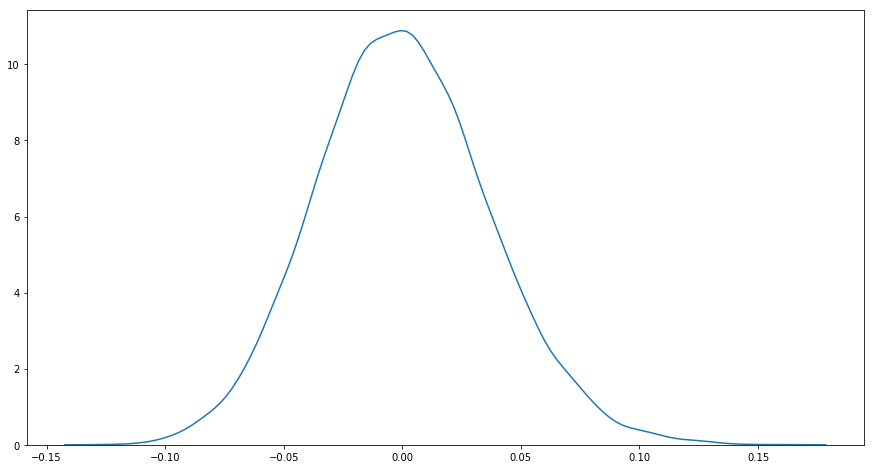

In [35]:
sea.kdeplot(Liste_mmd)

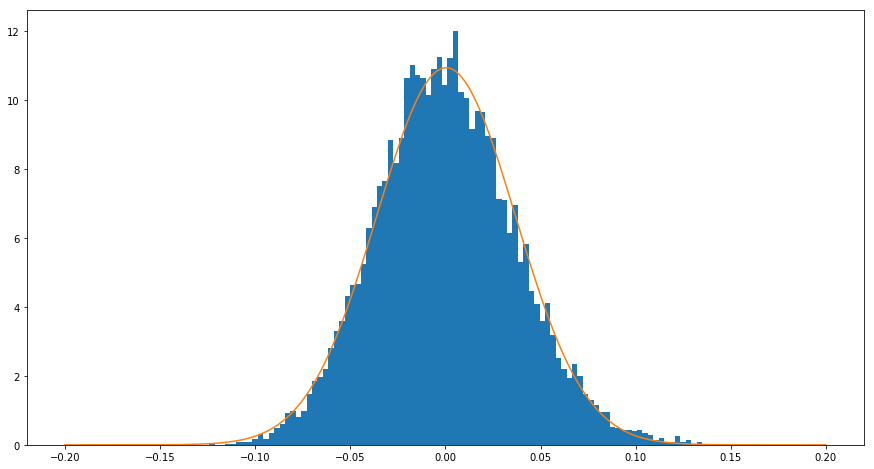

In [36]:
plt.hist(Liste_mmd,density=True,bins=100)
mean = np.mean(Liste_mmd)
std = np.std(Liste_mmd)
f_th = lambda x : 1/(np.sqrt(np.pi*2*std**2))*np.exp(-(x-mean)**2/(2*std**2))
X = np.linspace(-0.2,0.2,1000)
plt.plot(X,f_th(X))

The generated histogramm look pretty close from a gaussian curve.

### Variance

According to the theory, the variance can written as $V = 2v(\frac{1}{n} + \frac{1}{m})$

In [38]:
m = 1000
N = [20,50,100,200,500,1000,2000,5000]
variances = []
for n in N:
    print("******** n=", n, '************')
    repeat = 100
    Liste_mmd = []
    for _ in range(repeat):
        if (_%10==0):
            print(_/repeat*100, '% achevé',end='\r', flush=True)
        X = np.random.randn(m).reshape((-1,1))
        Y = np.random.randn(n).reshape((-1,1))
        kernel = laplacian(0.25)
        MMD =  MMD2l(X,kernel)
        for i in range(0,n//2):
            MMD.update(Y[2*i].reshape((-1,1)),Y[2*i+1].reshape((-1,1)))
        Liste_mmd.append(MMD.MMD[0])
    variances.append(np.std(Liste_mmd)**2)

******** n= 20 ************
******** n= 50 ************
******** n= 100 ************
******** n= 200 ************
******** n= 500 ************
******** n= 1000 ************
******** n= 2000 ************
******** n= 5000 ************


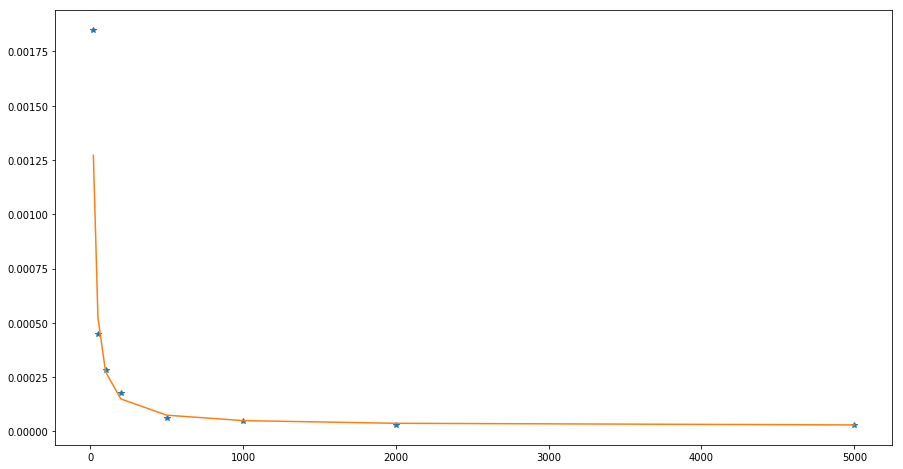

In [43]:
plt.plot(N,variances,'*')
f =(1/(np.r_[N]) + 1/(m))*0.0249356810691346
plt.plot(N,f)

If $m>>n$ then the variance become : $V = \frac{2v}{n}$ and so $\log{V} = -\log{n} + \log{2v}$

In [45]:
m = 100000
N = [20,50,100,200,500]
variances = []
for n in N:
    print("******** n=", n, '************')
    repeat = 100
    Liste_mmd = []
    for _ in range(repeat):
        if (_%10==0):
            print(_/repeat*100, '% achevé', end='\r',flush=True)
        X = np.random.randn(m).reshape((-1,1))
        Y = np.random.randn(n).reshape((-1,1))
        kernel = gaussian(2)
        MMD =  MMD2l(X,kernel)
        for i in range(0,n//2):
            MMD.update(Y[2*i].reshape((-1,1)),Y[2*i+1].reshape((-1,1)))
        Liste_mmd.append(MMD.MMD[0])
    variances.append(np.std(Liste_mmd)**2)

******** n= 20 ************
******** n= 50 ************
******** n= 100 ************
******** n= 200 ************
******** n= 500 ************


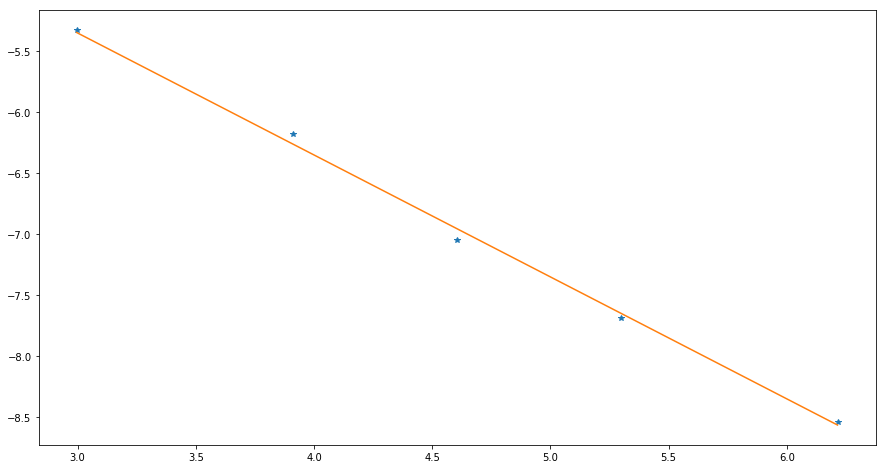

In [46]:
plt.plot(np.log(N),np.log(variances),'*')
plt.plot(np.log(N), (lambda x : -1*(x) +np.mean(np.log(N))+ np.mean(np.log(variances)))(np.log(N)))

We have checked that the variance evolve as expected when n and m change

### v factor

To checked that the estimator work well, we will create a database of v factor for different, p and kernel.

In [ ]:
data = pd.DataFrame(columns=["law_p","Kernel","parametre",'kernel_mean','kernel_variance','v'])

Kernel = ['gaussian','laplacian']
Ker = {}
Ker['gaussian'] = gaussian
Ker['laplacian'] = laplacian

parametre = [0.25, 0.5, 1, 2, 5]

size = [10,50,100,500,1000]

Law_p_ = ['normal_0_0', 'normal_0_10','normal_3_0','normal_3_10']
Law_p = {'normal_0_0':lambda size : np.random.randn(size).reshape(-1,1),
         'normal_0_10':lambda size : np.random.randn(size).reshape(-1,1)*sqrt(10),
         'normal_3_0':lambda size :3+ np.random.randn(size).reshape(-1,1),
         'normal_3_10':lambda size : 3+np.random.randn(size).reshape(-1,1)*sqrt(10),
}

N = [20,50,100,200,500]

ligne = 0
for law_p in Law_p:
    for kernel_ in Kernel:
        for p in parametre:
            print(ligne)
            kernel = Ker[kernel_](p)
            X = Law_p[law_p](1000)
            Y = Law_p[law_p](1000)
            XY = kernel(X,Y)
            var = XY.std()**2
            moy = XY.mean()
            m = 10000
            variances = []
            for n in N:
                repeat = 100
                Liste_mmd = []
                for _ in range(repeat):
                    X = Law_p[law_p](m)
                    Y = Law_p[law_p](n)
                    MMD =  MMD2l(X,kernel)
                    for i in range(0,n//2):
                        MMD.update(Y[2*i].reshape((-1,1)),Y[2*i+1].reshape((-1,1)))
                    Liste_mmd.append(MMD.MMD[0])
                variances.append(np.std(Liste_mmd)**2)
            v = np.exp(np.mean(np.log(variances)) + np.mean(np.log(N)))
            data.loc[ligne] = [law_p, kernel_, p, moy, var, v]
            ligne += 1

In [48]:
#data.to_csv("comparaison_mean_var_v.csv", encoding='utf-8', index=False) 
data = pd.read_csv("comparaison_mean_var_v.csv")
data.head()

,law_p,Kernel,parametre,kernel_mean,kernel_variance,v
0,normal_0_0,gaussian,0.25,0.334517,0.141015,0.219478
1,normal_0_0,gaussian,0.50,0.444543,0.126288,0.192694
2,normal_0_0,gaussian,1.00,0.582841,0.113517,0.149998
3,normal_0_0,gaussian,2.00,0.704856,0.072826,0.084680
4,normal_0_0,gaussian,5.00,0.846592,0.029359,0.032390


### CSP Estimator

According to the theory, the v factor, is equal to the variance of the Centered Scalar Product.
So $v = 2Var(k(X,X') - k(X,.) - k(.,X') + k(.,.))$

First, we build an estimator of $k(X,.)$

In [17]:
def est_partial_mean(kernel, law_p, x, repeat=100):
    X = law_p(repeat)
    return np.mean(kernel(x, X))

In [18]:
kernel = gaussian(0.25)
law_p = lambda size : np.random.randn(size).reshape(-1,1) 
est_partial_mean(kernel, law_p, 0)

0.5450062077019246

Then, we build an estimator of $k(.,.)$

In [19]:
def est_mean(kernel, law_p, repeat = 100):
    X = law_p(repeat)
    Y = law_p(repeat)
    XX, YY = np.meshgrid(X,Y)
    X_in = XX.reshape((-1,1))
    Y_in = YY.reshape((-1,1))
    return np.mean(kernel(X_in, Y_in))

In [20]:
kernel = laplacian(1)
law_p = lambda size : np.random.randn(size).reshape(-1,1) 
est_mean(kernel, law_p)

0.42702107779574705

We create a generator following the Centered Scalar Product law

In [21]:
def gen_CSP(kernel, law_p, size=1000):
    L = []
    for i in range(size):
        x = law_p(2)
        x1,x2 = x[0],x[1]
        gen = (kernel(np.r_[x1].reshape((1,1)),np.r_[x2].reshape((1,1))) 
               - est_partial_mean(kernel, law_p, x1) 
               - est_partial_mean(kernel, law_p, x2) 
               + est_mean(kernel, law_p))
        L.append(gen)
    return L

In [22]:
L = gen_CSP(kernel, law_p)
L = np.r_[L]
v = L.std()**2*2
print(f"The estimated v factor is {v:.3f}")

The estimated v factor is 0.105


We test the estimator with differents kernel and p

In [ ]:
data = pd.DataFrame(columns=["law_p","Kernel","parametre",'var_PNC'])

Kernel = ['gaussian','laplacian']
Ker = {}
Ker['gaussian'] = gaussian
Ker['laplacian'] = laplacian

parametre = [0.25, 0.5, 1, 2, 5]

size = [10,50,100,500,1000]

Law_p_ = ['normal_0_0', 'normal_0_10','normal_3_0','normal_3_10']
Law_p = {'normal_0_0':lambda size : np.random.randn(size).reshape(-1,1),
         'normal_0_10':lambda size : np.random.randn(size).reshape(-1,1)*sqrt(10),
         'normal_3_0':lambda size :3+ np.random.randn(size).reshape(-1,1),
         'normal_3_10':lambda size : 3+np.random.randn(size).reshape(-1,1)*sqrt(10),
}

N = [20,50,100,200,500]

ligne = 0
for law_p in Law_p:
    for kernel_ in Kernel:
        for p in parametre:
            kernel = Ker[kernel_](p)
            law = Law_p[law_p]
            L = gen_PNC(kernel, law);
            L = np.r_[L]
            data.loc[ligne] = [law_p, kernel_, p, L.std()**2*2]
            ligne += 1
            print(ligne,end='\r',flush=True)
data.to_csv("comparaison_PNC_var.csv", encoding='utf-8', index=False)

We can now comparing the estimated factor v and the mesured factor v.

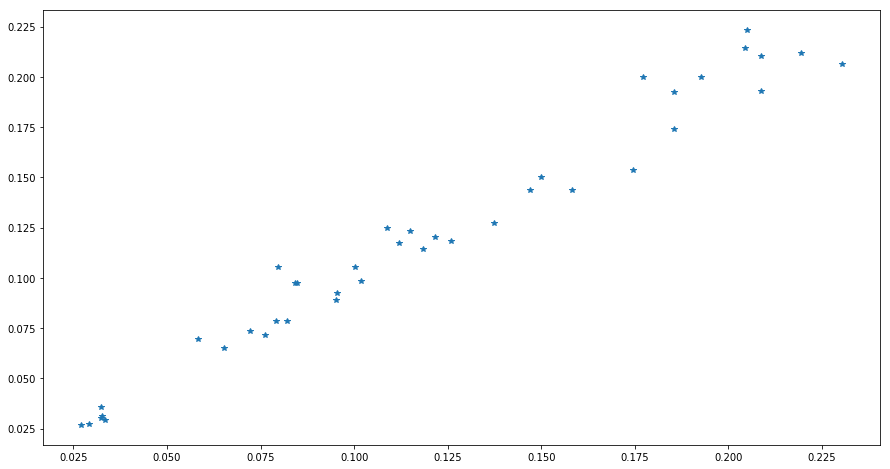

In [66]:
data1 = pd.read_csv("comparaison_mean_var_v.csv")
data2 = pd.read_csv("comparaison_PNC_var.csv")
plt.plot(data1['v'], data2['var_PNC'], '*')

We verified that the CSP_variance is a good estimator of the factor v.

### hk Estimator

During our research we find that the hk estimator (come from the first MMDl), work well to estimate th factor v.

In [23]:
def h_std_estimator(law_p,kernel, nb_turn = 10000):
    h_list = []
    for _ in range(nb_turn):
        X = law_p(4)
        x1, x2, y1, y2 = X[0].reshape((1,1)), X[1].reshape((1,1)), X[2].reshape((1,1)), X[3].reshape((1,1))
        h_list.append(kernel(x1,x2) + kernel(y1,y2)  - kernel(y1,x2) - kernel(x1,y2))
    return np.std(h_list)**2

In [24]:
kernel = laplacian(1)
law_p = lambda size : np.random.randn(size).reshape(-1,1) 
print(f"The estimated v factor is {h_std_estimator(law_p,kernel)/2:.3f}")

The estimated v factor is 0.104


We test the estimator with differents kernel and p

In [ ]:
data = pd.DataFrame(columns=["law_p","Kernel","parametre",'var_hk'])

Kernel = ['gaussian','laplacian']
Ker = {}
Ker['gaussian'] = gaussian
Ker['laplacian'] = laplacian

parametre = [0.25, 0.5, 1, 2, 5]

size = [10,50,100,500,1000]

Law_p_ = ['normal_0_0', 'normal_0_10','normal_3_0','normal_3_10']
Law_p = {'normal_0_0':lambda size : np.random.randn(size).reshape(-1,1),
         'normal_0_10':lambda size : np.random.randn(size).reshape(-1,1)*sqrt(10),
         'normal_3_0':lambda size :3+ np.random.randn(size).reshape(-1,1),
         'normal_3_10':lambda size : 3+np.random.randn(size).reshape(-1,1)*sqrt(10),
}

N = [20,50,100,200,500]

ligne = 0
for law_p in Law_p:
    for kernel_ in Kernel:
        for p in parametre:
            kernel = Ker[kernel_](p)
            law = Law_p[law_p]
            data.loc[ligne] = [law_p, kernel_, p, h_std_estimator(law,kernel)/2]
            ligne += 1
            print(ligne)
data.to_csv("comparaison_hk_var.csv", encoding='utf-8', index=False)  

We can now comparing the estimated factor v and the mesured factor v.

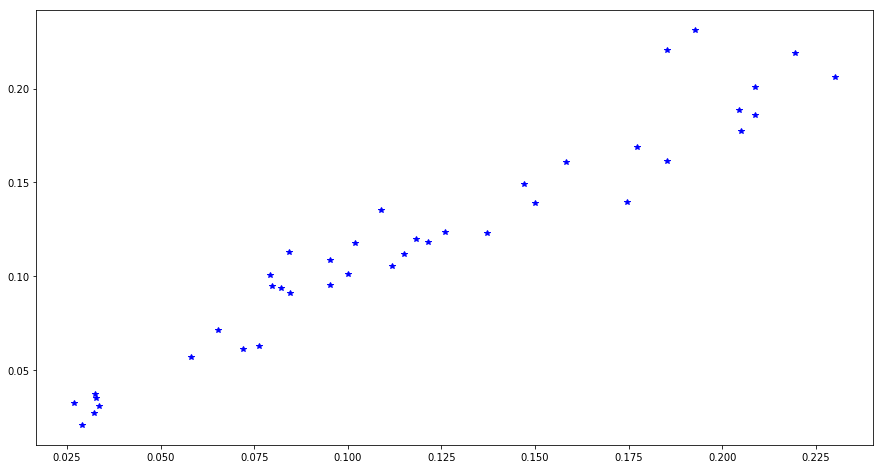

In [76]:
data1 = pd.read_csv("comparaison_mean_var_v.csv")
data2 = pd.read_csv("comparaison_hk_var.csv")
plt.plot(data1['v'], data2['var_hk'], 'b*')

We can also compare the 2 estimators.

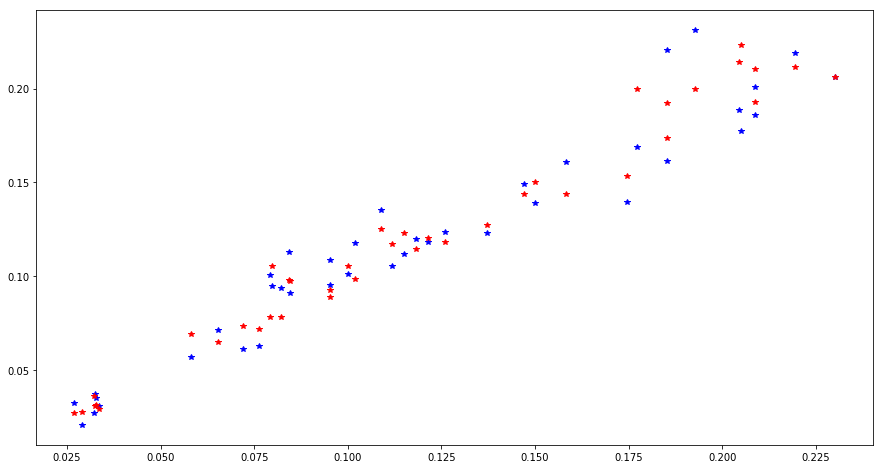

In [78]:
data1 = pd.read_csv("comparaison_mean_var_v.csv")
data2 = pd.read_csv("comparaison_hk_var.csv")
plt.plot(data1['v'], data2['var_hk'], 'b*')
data2 = pd.read_csv("comparaison_PNC_var.csv")
plt.plot(data1['v'], data2['var_PNC'], 'r*')

As far, there is no really, differences between the two estimators.

### Compare the MMDl estimators

In the case $m=n$.
According to Gretton et al., 2012 we have 
$MMDl \rightarrow N(0,\frac{2\sigma^2}{n})$<br>
According the previous results, we have $MMD2l \rightarrow N(0,\frac{\sigma^2}{n})$<br>
So MMD2l have the same law of MMD, expect with a variance divide by 2.<br>
That make sense becauce of the quadratic term in MMD2l.

In [16]:
m = 1000
n = 1000
repeat = 1000
Liste_mmd = []
Liste_mmdl = []
for _ in range(repeat):
    if (_%10==0):
        print(_/repeat*100, '% achevé',end='\r',flush=True)
    X = np.random.randn(m).reshape((-1,1))
    Y = np.random.randn(n).reshape((-1,1))
    kernel = laplacian(2)
    
    MMD =  MMD2l(X,kernel)
    for i in range(0,n//2):
        MMD.update(Y[2*i].reshape((-1,1)),Y[2*i+1].reshape((-1,1)))
    Liste_mmd.append(MMD.MMD[0])
    
    
    Liste_mmdl.append(MMDl(X[:n],Y[:n],kernel))

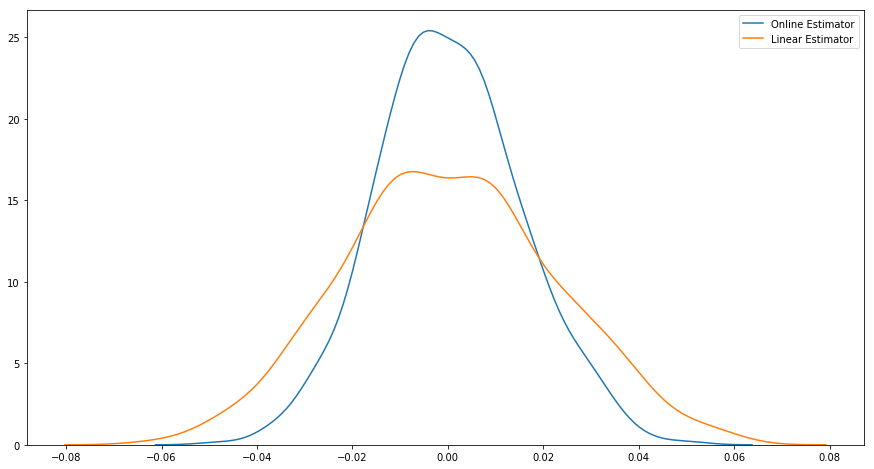

In [27]:
import seaborn as sns
sns.kdeplot(Liste_mmd, label="Online Estimator")
sns.kdeplot(Liste_mmdl, label="Linear Estimator")
plt.savefig("OnlineVSLinear.eps")

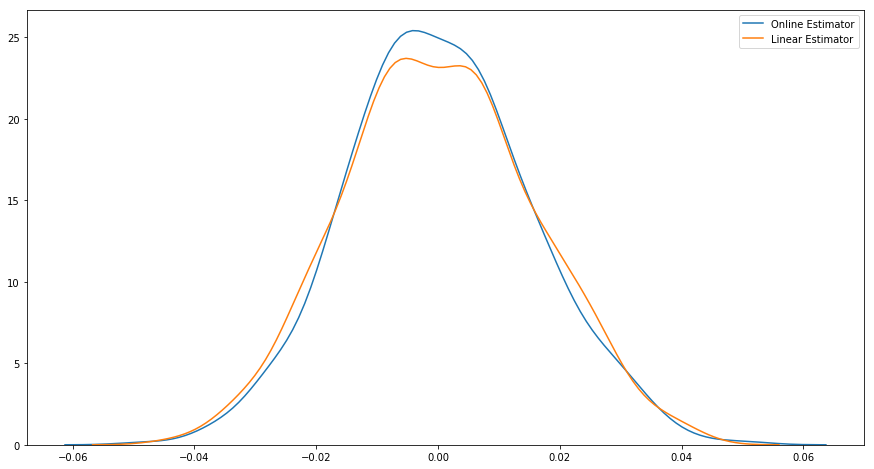

In [22]:
sns.kdeplot(Liste_mmd, label="Online Estimator")
sns.kdeplot(Liste_mmdl/np.sqrt(2), label="Linear Estimator")

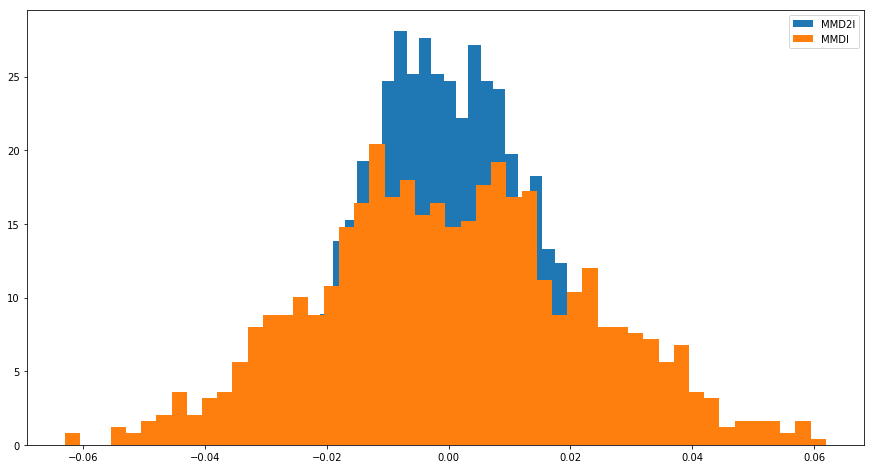

<Figure size 1080x576 with 0 Axes>

In [17]:
plt.hist(Liste_mmd,density=True,bins=50, label="MMD2l")
plt.hist(Liste_mmdl,density=True,bins=50, label="MMDl")
plt.legend()
plt.show()
plt.savefig("LinearVSOnline.png")

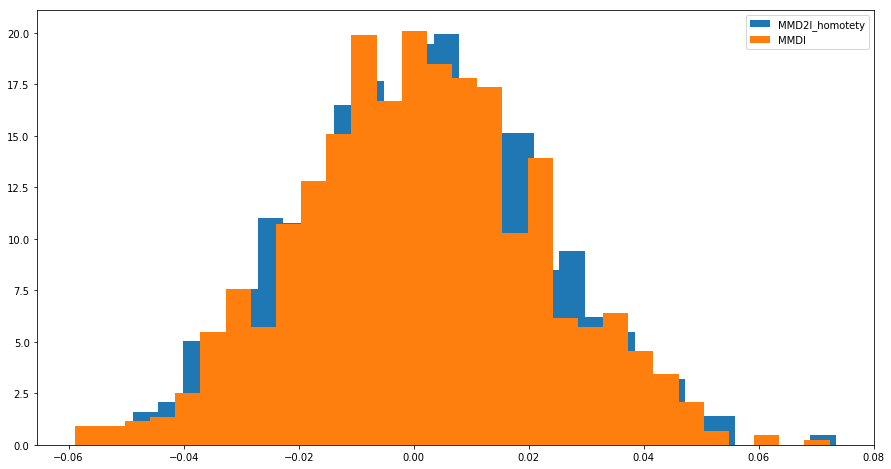

In [183]:
plt.hist(np.array(Liste_mmd)*sqrt(2),density=True,bins=30,label="MMD2l_homotety")
plt.hist(np.array(Liste_mmdl),density=True,bins=30, label="MMDl")
plt.legend();

# Test Online

Yet we know the asymptotique law of MMD2l, it is easy to build a 5%-error reject hypotethis treshold.<br>
$$t_5 =2\sigma =  2\sqrt{2v(\frac{1}{m} + \frac{1}{n})}$$

In [25]:
def h_std_estimator(X,kernel, nb_turn = 100):
    x = X[:X.shape[0]//2,:]
    y = X[X.shape[0]//2:,:]
    indices = np.arange(0,X.shape[0]//2,2)
    h_list = []
    for _ in range(nb_turn):
        i = np.random.choice(indices, size = 1, replace=True)
        h_list.append(kernel(x[i],x[i+1]) + kernel(y[i],y[i+1]) - kernel(y[i],x[i+1]) - kernel(x[i],y[i+1]))
    return np.std(h_list)**2/2

In [26]:
class MMD2l():
    def __init__(self,X,kernel):
        self.X = X
        self.Y = []
        self.m = X.shape[0]
        self.n = 0
        self.kernel = kernel
        
        X_, Y_ = X[0::2,:],X[1::2,:]
        self.estim_normP = 2/self.m*self.kernel(X_,Y_).sum()
        
        self.sumNormQ = 0
        self.sumPS = 0
        
        self.MMD = self.estim_normP 
        
        self.factor_V()
        
    def factor_V(self):
        self.factor_v = h_std_estimator(self.X,self.kernel, nb_turn = 100)
    
    def treshold(self):
        return 2*np.sqrt(self.factor_v*(1/self.n+1/self.m))
    
    def update(self,y1,y2):
        self.sumNormQ += self.kernel(y1,y2)
        
        self.sumPS += self.kernel(X,y1).sum() + self.kernel(X,y2).sum()
        
        self.n += 2
        
        self.MMD = self.estim_normP + 2/self.n * self.sumNormQ - 2/(self.n*self.m)*self.sumPS
        
    def check(self):
        return np.abs(self.MMD) < self.treshold() 

NameError: name 'treshold_estimator' is not defined

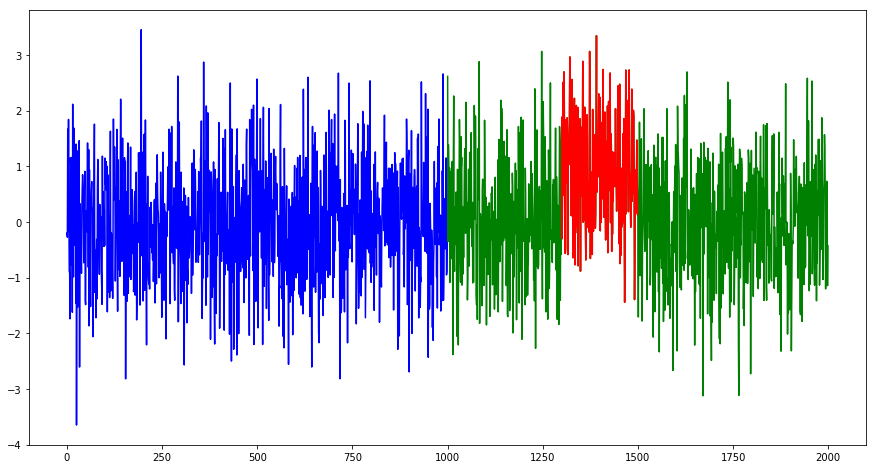

In [27]:
X = np.random.randn(1000).reshape((1000,1))
Y = np.random.randn(1000).reshape((1000,1))
Y[300:500] += 1
plt.plot(range(1000),X,'b')
plt.plot(range(1000,2000),Y,'g')
plt.plot(range(1300,1500),Y[300:500],'r')
treshold_estimator(X.reshape(1000),lambda x,y: MMDl(x,y,gaussian(5)),100, nb_turn = 100)

In [259]:
m = 1000
n = 1000
Liste_mmd = []
if (_%100==0):
    print(_/repeat*100, '% achevé',end='\r', flush=True)
kernel = gaussian(5)
MMD =  MMD2l(X,kernel)
for i in range(0,n//2):
    MMD.update(Y[2*i].reshape((-1,1)),Y[2*i+1].reshape((-1,1)))
    Liste_mmd.append(MMD.MMD[0])

/home/kronert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kronert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


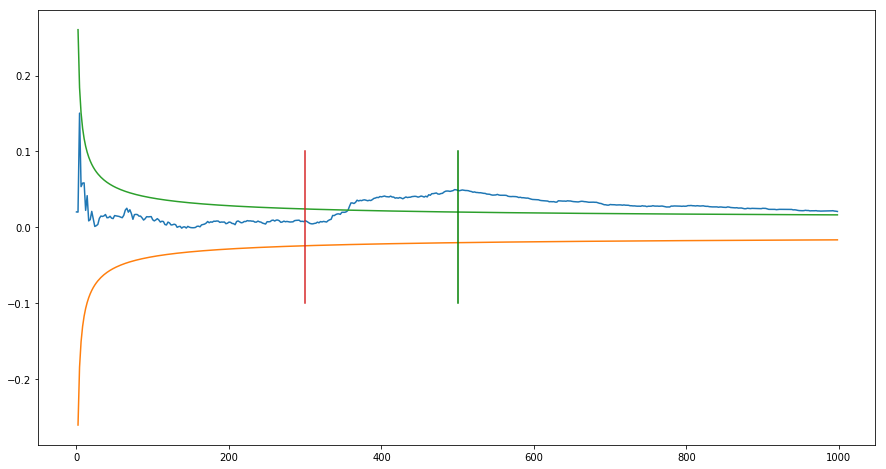

In [260]:
T = np.arange(0,1000,2)
plt.plot(T, Liste_mmd)
plt.plot(T,-2*np.sqrt(MMD.factor_v*(1/T+1/MMD.m)))
plt.plot(T,2*np.sqrt(MMD.factor_v*(1/T+1/MMD.m)))
plt.plot([300,300],[0.1,-0.1])
plt.plot([500,500],[0.1,-0.1],'g')

### Temps avant fausse alerte

/home/kronert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/home/kronert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


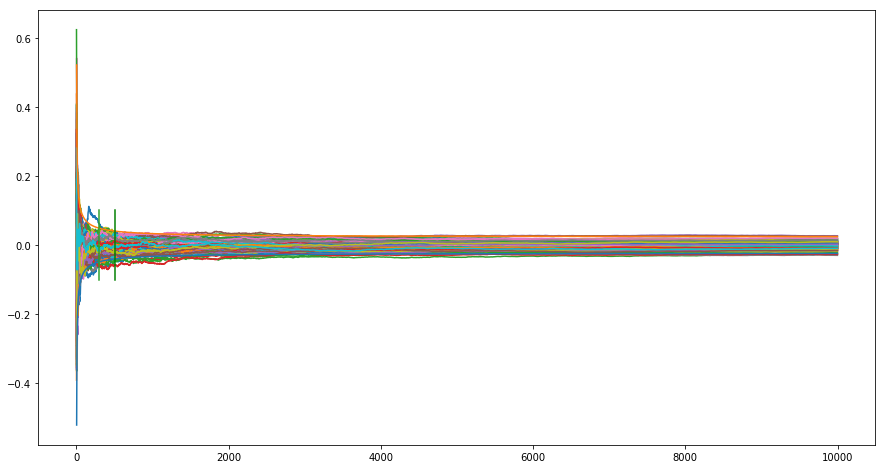

In [288]:
Detect =  np.zeros((100, n//2))
for k in range(100):
    X = np.random.randn(1000).reshape((1000,1))
    Y = np.random.randn(10000).reshape((10000,1))
    Y[300:500] += 0
    treshold_estimator(X.reshape(1000),lambda x,y: MMDl(x,y,gaussian(1)),100, nb_turn = 100)

    m = 1000
    n = 10000
    Liste_mmd = []
    detect = np.zeros(n//2)
    thr = np.zeros(n//2)
    if (_%100==0):
        print(_/repeat*100, '% achevé',end='\r', flush=True)
    kernel = gaussian(1)
    MMD =  MMD2l(X,kernel)
    for i in range(0,n//2):
        MMD.update(Y[2*i].reshape((-1,1)),Y[2*i+1].reshape((-1,1)))
        Liste_mmd.append(MMD.MMD[0])
        detect[i] = 1 - MMD.check()
        thr[i] = MMD.treshold()
    T = np.arange(0,n,2)
    plt.plot(T, Liste_mmd)
    Detect[k] = detect
    print(k, end='\r', flush=True)
plt.plot(T,-2*np.sqrt(MMD.factor_v*(1/T+1/MMD.m)))
plt.plot(T,2*np.sqrt(MMD.factor_v*(1/T+1/MMD.m)))
plt.plot([300,300],[0.1,-0.1])
plt.plot([500,500],[0.1,-0.1],'g')

temps avant détection : 100


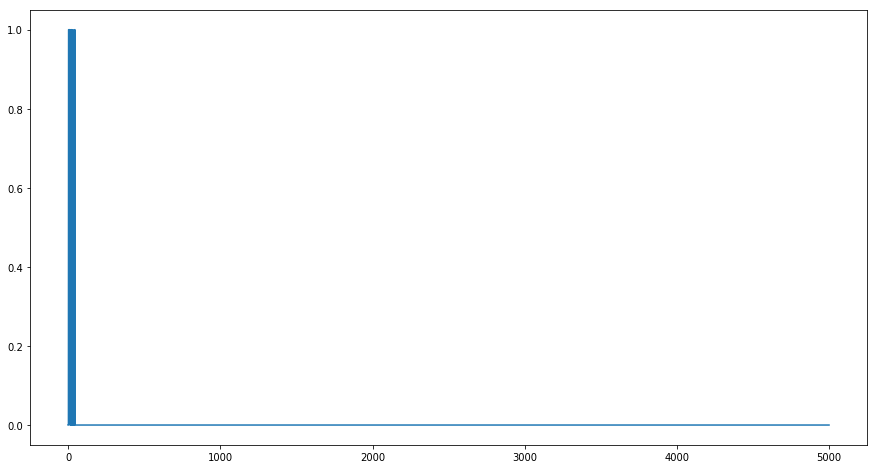

In [286]:
detect_ = 1-detect
plt.plot(detect_)
print(f"temps avant détection : {np.argmax(detect_[100:]) + 100}")

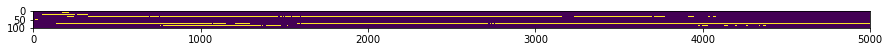

In [309]:
plt.imshow(Detect)

In [324]:
print(f"Proportion de fausse alerte {Detect.mean()*100}%")
print(f"Proportion de trajectoire avec fausse alerte {np.max(Detect,axis=1).mean()*100}%")
print(f"Moyenne des temps avant fausse alerte {np.argmax(Detect[np.max(Detect,axis=1)==1],axis=1).mean() }")


Proportion de fausse alerte 3.5502%
Proportion de trajectoire avec fausse alerte 40.0%
Moyenne des temps avant fausse alerte 163.975


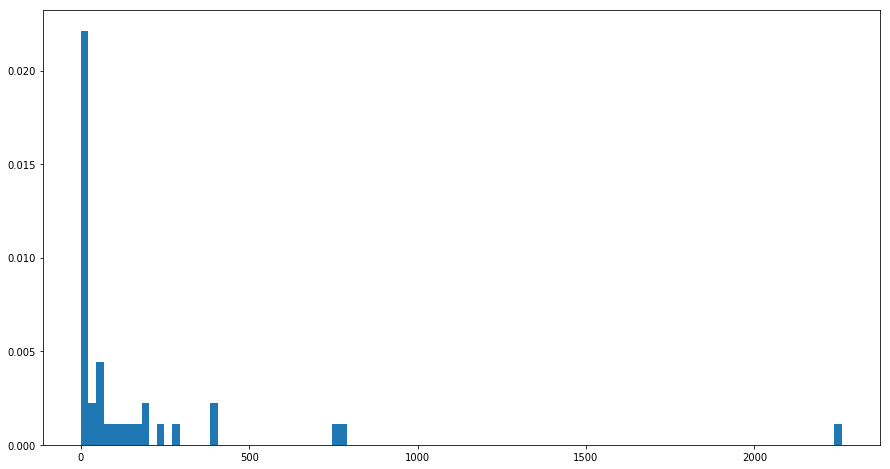

In [328]:
plt.hist(np.argmax(Detect[np.max(Detect,axis=1)==1],axis=1),bins=100, density=1);


/home/kronert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/home/kronert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


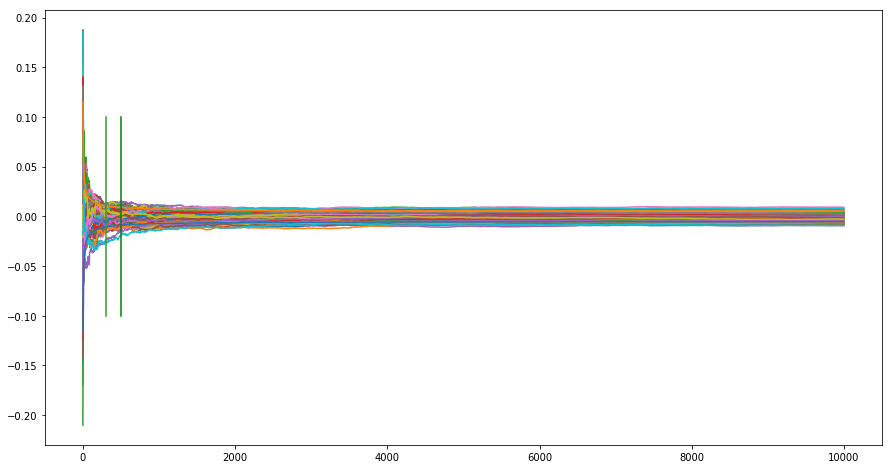

In [329]:
Detect =  np.zeros((100, n//2))
for k in range(100):
    X = np.random.randn(1000).reshape((1000,1))
    Y = np.random.randn(10000).reshape((10000,1))
    Y[300:500] += 0
    treshold_estimator(X.reshape(1000),lambda x,y: MMDl(x,y,gaussian(10)),100, nb_turn = 100)

    m = 1000
    n = 10000
    Liste_mmd = []
    detect = np.zeros(n//2)
    thr = np.zeros(n//2)
    if (_%100==0):
        print(_/repeat*100, '% achevé',end='\r', flush=True)
    kernel = gaussian(10)
    MMD =  MMD2l(X,kernel)
    for i in range(0,n//2):
        MMD.update(Y[2*i].reshape((-1,1)),Y[2*i+1].reshape((-1,1)))
        Liste_mmd.append(MMD.MMD[0])
        detect[i] = 1 - MMD.check()
        thr[i] = MMD.treshold()
    T = np.arange(0,n,2)
    plt.plot(T, Liste_mmd)
    Detect[k] = detect
    print(k, end='\r', flush=True)
plt.plot(T,-2*np.sqrt(MMD.factor_v*(1/T+1/MMD.m)))
plt.plot(T,2*np.sqrt(MMD.factor_v*(1/T+1/MMD.m)))
plt.plot([300,300],[0.1,-0.1])
plt.plot([500,500],[0.1,-0.1],'g')

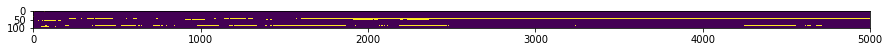

In [330]:
plt.imshow(Detect)

In [331]:
print(f"Proportion de fausse alerte {Detect.mean()*100}%")
print(f"Proportion de trajectoire avec fausse alerte {np.max(Detect,axis=1).mean()*100}%")
print(f"Moyenne des temps avant fausse alerte {np.argmax(Detect[np.max(Detect,axis=1)==1],axis=1).mean() }")

Proportion de fausse alerte 9.628200000000001%
Proportion de trajectoire avec fausse alerte 47.0%
Moyenne des temps avant fausse alerte 203.40425531914894


/home/kronert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/home/kronert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


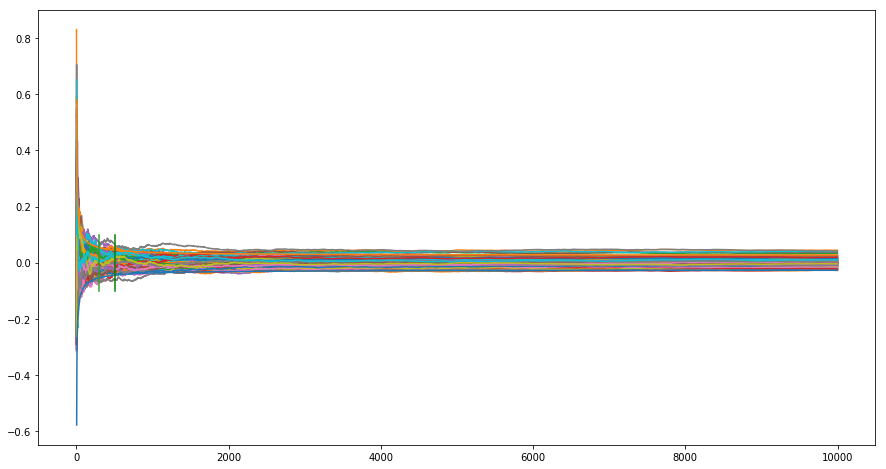

In [332]:
Detect =  np.zeros((100, n//2))
for k in range(100):
    X = np.random.randn(1000).reshape((1000,1))
    Y = np.random.randn(10000).reshape((10000,1))
    Y[300:500] += 0
    treshold_estimator(X.reshape(1000),lambda x,y: MMDl(x,y,gaussian(.1)),100, nb_turn = 100)

    m = 1000
    n = 10000
    Liste_mmd = []
    detect = np.zeros(n//2)
    thr = np.zeros(n//2)
    if (_%100==0):
        print(_/repeat*100, '% achevé',end='\r', flush=True)
    kernel = gaussian(.1)
    MMD =  MMD2l(X,kernel)
    for i in range(0,n//2):
        MMD.update(Y[2*i].reshape((-1,1)),Y[2*i+1].reshape((-1,1)))
        Liste_mmd.append(MMD.MMD[0])
        detect[i] = 1 - MMD.check()
        thr[i] = MMD.treshold()
    T = np.arange(0,n,2)
    plt.plot(T, Liste_mmd)
    Detect[k] = detect
    print(k, end='\r', flush=True)
plt.plot(T,-2*np.sqrt(MMD.factor_v*(1/T+1/MMD.m)))
plt.plot(T,2*np.sqrt(MMD.factor_v*(1/T+1/MMD.m)))
plt.plot([300,300],[0.1,-0.1])
plt.plot([500,500],[0.1,-0.1],'g')

In [333]:
print(f"Proportion de fausse alerte {Detect.mean()*100}%")
print(f"Proportion de trajectoire avec fausse alerte {np.max(Detect,axis=1).mean()*100}%")
print(f"Moyenne des temps avant fausse alerte {np.argmax(Detect[np.max(Detect,axis=1)==1],axis=1).mean() }")

Proportion de fausse alerte 6.587%
Proportion de trajectoire avec fausse alerte 49.0%
Moyenne des temps avant fausse alerte 113.9795918367347


/home/kronert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/home/kronert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


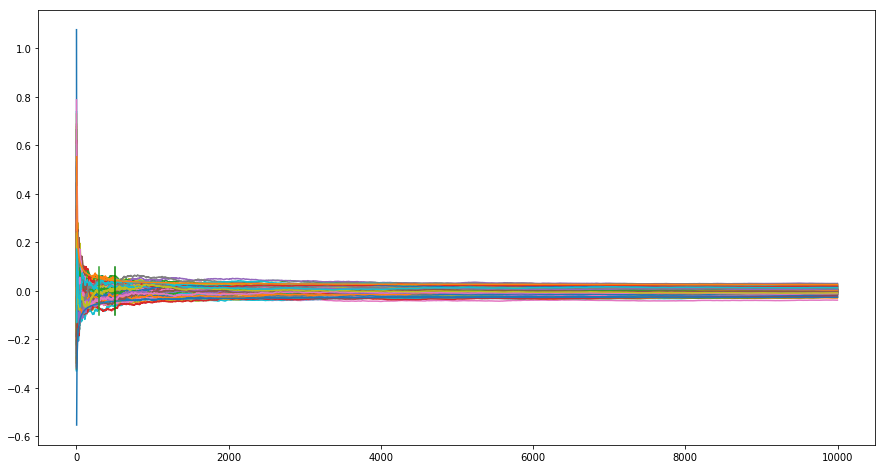

In [334]:
Detect =  np.zeros((100, n//2))
for k in range(100):
    X = np.random.randn(1000).reshape((1000,1))*10
    Y = np.random.randn(10000).reshape((10000,1))*10
    Y[300:500] += 0
    treshold_estimator(X.reshape(1000),lambda x,y: MMDl(x,y,gaussian(10)),100, nb_turn = 100)

    m = 1000
    n = 10000
    Liste_mmd = []
    detect = np.zeros(n//2)
    thr = np.zeros(n//2)
    if (_%100==0):
        print(_/repeat*100, '% achevé',end='\r', flush=True)
    kernel = gaussian(10)
    MMD =  MMD2l(X,kernel)
    for i in range(0,n//2):
        MMD.update(Y[2*i].reshape((-1,1)),Y[2*i+1].reshape((-1,1)))
        Liste_mmd.append(MMD.MMD[0])
        detect[i] = 1 - MMD.check()
        thr[i] = MMD.treshold()
    T = np.arange(0,n,2)
    plt.plot(T, Liste_mmd)
    Detect[k] = detect
    print(k, end='\r', flush=True)
plt.plot(T,-2*np.sqrt(MMD.factor_v*(1/T+1/MMD.m)))
plt.plot(T,2*np.sqrt(MMD.factor_v*(1/T+1/MMD.m)))
plt.plot([300,300],[0.1,-0.1])
plt.plot([500,500],[0.1,-0.1],'g')

In [335]:
print(f"Proportion de fausse alerte {Detect.mean()*100}%")
print(f"Proportion de trajectoire avec fausse alerte {np.max(Detect,axis=1).mean()*100}%")
print(f"Moyenne des temps avant fausse alerte {np.argmax(Detect[np.max(Detect,axis=1)==1],axis=1).mean() }")

Proportion de fausse alerte 6.2303999999999995%
Proportion de trajectoire avec fausse alerte 56.00000000000001%
Moyenne des temps avant fausse alerte 124.16071428571429


/home/kronert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/home/kronert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


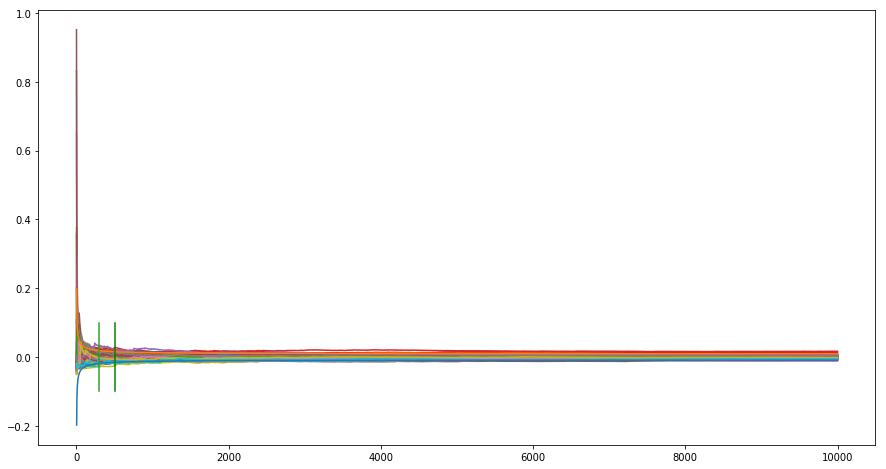

In [336]:
Detect =  np.zeros((100, n//2))
for k in range(100):
    X = np.random.randn(1000).reshape((1000,1))*10
    Y = np.random.randn(10000).reshape((10000,1))*10
    Y[300:500] += 0
    treshold_estimator(X.reshape(1000),lambda x,y: MMDl(x,y,gaussian(0.1)),100, nb_turn = 100)

    m = 1000
    n = 10000
    Liste_mmd = []
    detect = np.zeros(n//2)
    thr = np.zeros(n//2)
    if (_%100==0):
        print(_/repeat*100, '% achevé',end='\r', flush=True)
    kernel = gaussian(0.1)
    MMD =  MMD2l(X,kernel)
    for i in range(0,n//2):
        MMD.update(Y[2*i].reshape((-1,1)),Y[2*i+1].reshape((-1,1)))
        Liste_mmd.append(MMD.MMD[0])
        detect[i] = 1 - MMD.check()
        thr[i] = MMD.treshold()
    T = np.arange(0,n,2)
    plt.plot(T, Liste_mmd)
    Detect[k] = detect
    print(k, end='\r', flush=True)
plt.plot(T,-2*np.sqrt(MMD.factor_v*(1/T+1/MMD.m)))
plt.plot(T,2*np.sqrt(MMD.factor_v*(1/T+1/MMD.m)))
plt.plot([300,300],[0.1,-0.1])
plt.plot([500,500],[0.1,-0.1],'g')

In [337]:
print(f"Proportion de fausse alerte {Detect.mean()*100}%")
print(f"Proportion de trajectoire avec fausse alerte {np.max(Detect,axis=1).mean()*100}%")
print(f"Moyenne des temps avant fausse alerte {np.argmax(Detect[np.max(Detect,axis=1)==1],axis=1).mean() }")

Proportion de fausse alerte 7.1726%
Proportion de trajectoire avec fausse alerte 45.0%
Moyenne des temps avant fausse alerte 120.88888888888889


/home/kronert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/home/kronert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


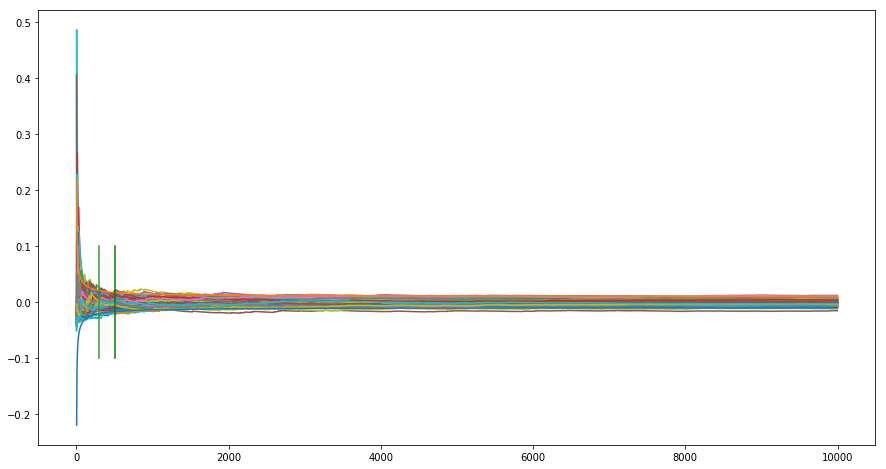

In [338]:
Detect =  np.zeros((100, n//2))
for k in range(100):
    X = np.random.randn(1000).reshape((1000,1))*10
    Y = np.random.randn(10000).reshape((10000,1))*10
    Y[300:500] += 0
    treshold_estimator(X.reshape(1000),lambda x,y: MMDl(x,y,gaussian(0.1)),100, nb_turn = 100)

    m = 1000
    n = 10000
    Liste_mmd = []
    detect = np.zeros(n//2)
    thr = np.zeros(n//2)
    if (_%100==0):
        print(_/repeat*100, '% achevé',end='\r', flush=True)
    kernel = gaussian(0.1)
    MMD =  MMD2l(X,kernel)
    for i in range(0,n//2):
        MMD.update(Y[2*i].reshape((-1,1)),Y[2*i+1].reshape((-1,1)))
        Liste_mmd.append(MMD.MMD[0])
        detect[i] = 1 - MMD.check()
        thr[i] = MMD.treshold()
    T = np.arange(0,n,2)
    plt.plot(T, Liste_mmd)
    Detect[k] = detect
    print(k, end='\r', flush=True)
plt.plot(T,-2*np.sqrt(MMD.factor_v*(1/T+1/MMD.m)))
plt.plot(T,2*np.sqrt(MMD.factor_v*(1/T+1/MMD.m)))
plt.plot([300,300],[0.1,-0.1])
plt.plot([500,500],[0.1,-0.1],'g')

In [339]:
print(f"Proportion de fausse alerte {Detect.mean()*100}%")
print(f"Proportion de trajectoire avec fausse alerte {np.max(Detect,axis=1).mean()*100}%")
print(f"Moyenne des temps avant fausse alerte {np.argmax(Detect[np.max(Detect,axis=1)==1],axis=1).mean() }")

Proportion de fausse alerte 5.9702%
Proportion de trajectoire avec fausse alerte 40.0%
Moyenne des temps avant fausse alerte 126.4


Proportion de fausse alerte 4.26%
Proportion de trajectoire avec fausse alerte 22.0%
Moyenne des temps avant fausse alerte 18.772727272727273


/home/kronert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/home/kronert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide


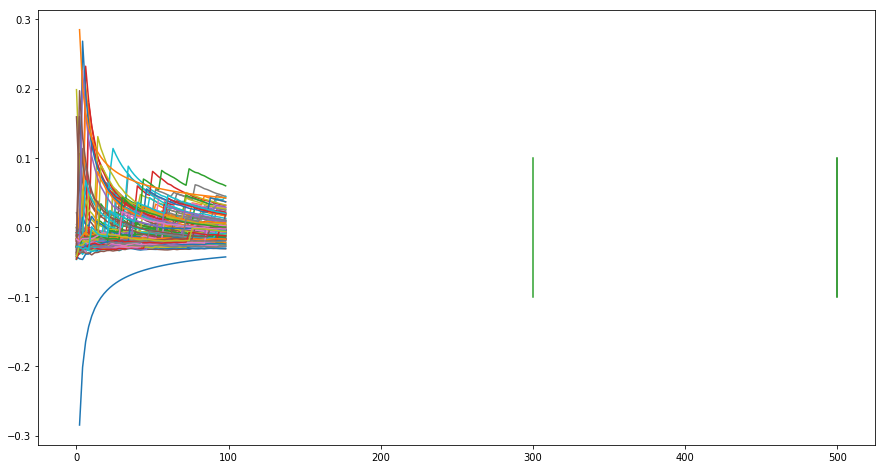

In [31]:
m = 1000
n = 100
Detect =  np.zeros((100, n//2))
for k in range(100):
    X = np.random.randn(1000).reshape((1000,1))*10
    Y = np.random.randn(10000).reshape((10000,1))*10
    Y[300:500] += 0
    treshold_estimator(X.reshape(1000),lambda x,y: MMDl(x,y,gaussian(0.1)),100, nb_turn = 100)

    
    Liste_mmd = []
    detect = np.zeros(n//2)
    thr = np.zeros(n//2)
    if (_%100==0):
        print(_/repeat*100, '% achevé',end='\r', flush=True)
    kernel = gaussian(0.1)
    MMD =  MMD2l(X,kernel)
    for i in range(0,n//2):
        MMD.update(Y[2*i].reshape((-1,1)),Y[2*i+1].reshape((-1,1)))
        Liste_mmd.append(MMD.MMD[0])
        detect[i] = 1 - MMD.check()
        thr[i] = MMD.treshold()
    T = np.arange(0,n,2)
    plt.plot(T, Liste_mmd)
    Detect[k] = detect
    print(k, end='\r', flush=True)
plt.plot(T,-2*np.sqrt(MMD.factor_v*(1/T+1/MMD.m)))
plt.plot(T,2*np.sqrt(MMD.factor_v*(1/T+1/MMD.m)))
plt.plot([300,300],[0.1,-0.1])
plt.plot([500,500],[0.1,-0.1],'g')

print(f"Proportion de fausse alerte {Detect.mean()*100}%")
print(f"Proportion de trajectoire avec fausse alerte {np.max(Detect,axis=1).mean()*100}%")
print(f"Moyenne des temps avant fausse alerte {np.argmax(Detect[np.max(Detect,axis=1)==1],axis=1).mean() }")

Proportion de fausse alerte 6.6000000000000005%
Proportion de trajectoire avec fausse alerte 36.0%
Moyenne des temps avant fausse alerte 24.36111111111111


/home/kronert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/home/kronert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide


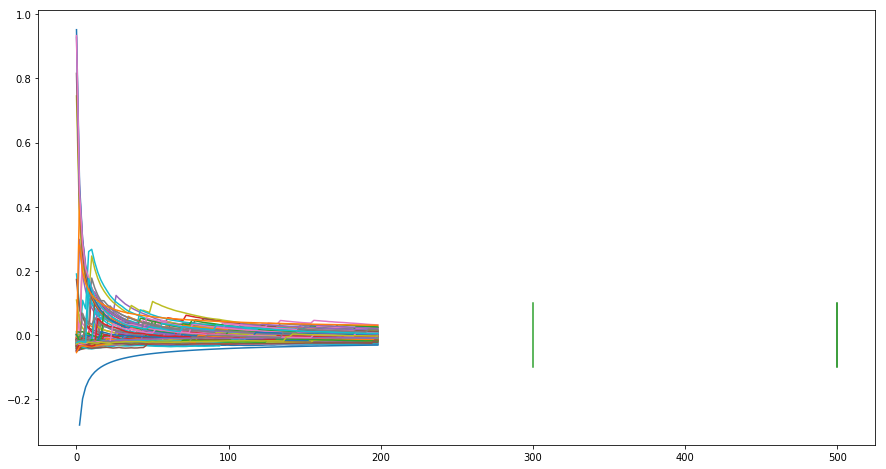

In [32]:
m = 1000
n = 200
Detect =  np.zeros((100, n//2))
for k in range(100):
    X = np.random.randn(1000).reshape((1000,1))*10
    Y = np.random.randn(10000).reshape((10000,1))*10
    Y[300:500] += 0
    treshold_estimator(X.reshape(1000),lambda x,y: MMDl(x,y,gaussian(0.1)),100, nb_turn = 100)

    
    Liste_mmd = []
    detect = np.zeros(n//2)
    thr = np.zeros(n//2)
    if (_%100==0):
        print(_/repeat*100, '% achevé',end='\r', flush=True)
    kernel = gaussian(0.1)
    MMD =  MMD2l(X,kernel)
    for i in range(0,n//2):
        MMD.update(Y[2*i].reshape((-1,1)),Y[2*i+1].reshape((-1,1)))
        Liste_mmd.append(MMD.MMD[0])
        detect[i] = 1 - MMD.check()
        thr[i] = MMD.treshold()
    T = np.arange(0,n,2)
    plt.plot(T, Liste_mmd)
    Detect[k] = detect
    print(k, end='\r', flush=True)
plt.plot(T,-2*np.sqrt(MMD.factor_v*(1/T+1/MMD.m)))
plt.plot(T,2*np.sqrt(MMD.factor_v*(1/T+1/MMD.m)))
plt.plot([300,300],[0.1,-0.1])
plt.plot([500,500],[0.1,-0.1],'g')

print(f"Proportion de fausse alerte {Detect.mean()*100}%")
print(f"Proportion de trajectoire avec fausse alerte {np.max(Detect,axis=1).mean()*100}%")
print(f"Moyenne des temps avant fausse alerte {np.argmax(Detect[np.max(Detect,axis=1)==1],axis=1).mean() }")

Proportion de fausse alerte 6.266666666666667%
Proportion de trajectoire avec fausse alerte 37.0%
Moyenne des temps avant fausse alerte 28.62162162162162


/home/kronert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/home/kronert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide


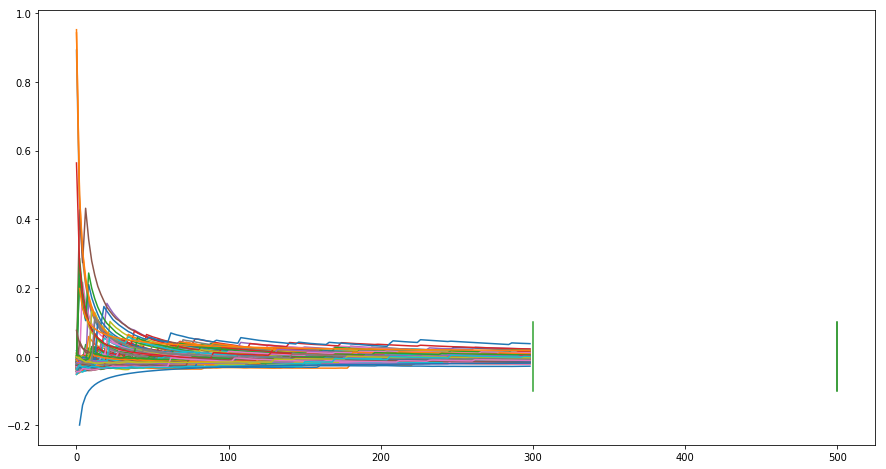

In [33]:
m = 1000
n = 300
Detect =  np.zeros((100, n//2))
for k in range(100):
    X = np.random.randn(1000).reshape((1000,1))*10
    Y = np.random.randn(10000).reshape((10000,1))*10
    Y[300:500] += 0
    treshold_estimator(X.reshape(1000),lambda x,y: MMDl(x,y,gaussian(0.1)),100, nb_turn = 100)

    
    Liste_mmd = []
    detect = np.zeros(n//2)
    thr = np.zeros(n//2)
    if (_%100==0):
        print(_/repeat*100, '% achevé',end='\r', flush=True)
    kernel = gaussian(0.1)
    MMD =  MMD2l(X,kernel)
    for i in range(0,n//2):
        MMD.update(Y[2*i].reshape((-1,1)),Y[2*i+1].reshape((-1,1)))
        Liste_mmd.append(MMD.MMD[0])
        detect[i] = 1 - MMD.check()
        thr[i] = MMD.treshold()
    T = np.arange(0,n,2)
    plt.plot(T, Liste_mmd)
    Detect[k] = detect
    print(k, end='\r', flush=True)
plt.plot(T,-2*np.sqrt(MMD.factor_v*(1/T+1/MMD.m)))
plt.plot(T,2*np.sqrt(MMD.factor_v*(1/T+1/MMD.m)))
plt.plot([300,300],[0.1,-0.1])
plt.plot([500,500],[0.1,-0.1],'g')

print(f"Proportion de fausse alerte {Detect.mean()*100}%")
print(f"Proportion de trajectoire avec fausse alerte {np.max(Detect,axis=1).mean()*100}%")
print(f"Moyenne des temps avant fausse alerte {np.argmax(Detect[np.max(Detect,axis=1)==1],axis=1).mean() }")

Proportion de fausse alerte 6.58%
Proportion de trajectoire avec fausse alerte 38.0%
Moyenne des temps avant fausse alerte 33.76315789473684


/home/kronert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/home/kronert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide


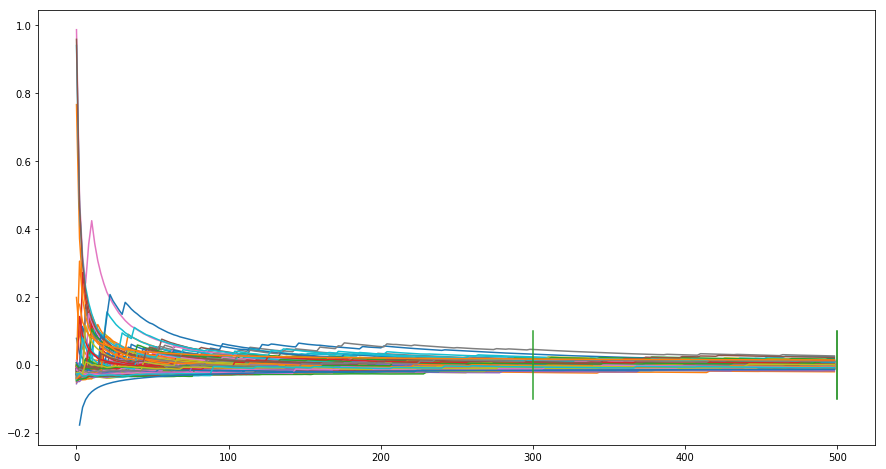

In [34]:
m = 1000
n = 500
Detect =  np.zeros((100, n//2))
for k in range(100):
    X = np.random.randn(1000).reshape((1000,1))*10
    Y = np.random.randn(10000).reshape((10000,1))*10
    Y[300:500] += 0
    treshold_estimator(X.reshape(1000),lambda x,y: MMDl(x,y,gaussian(0.1)),100, nb_turn = 100)

    
    Liste_mmd = []
    detect = np.zeros(n//2)
    thr = np.zeros(n//2)
    if (_%100==0):
        print(_/repeat*100, '% achevé',end='\r', flush=True)
    kernel = gaussian(0.1)
    MMD =  MMD2l(X,kernel)
    for i in range(0,n//2):
        MMD.update(Y[2*i].reshape((-1,1)),Y[2*i+1].reshape((-1,1)))
        Liste_mmd.append(MMD.MMD[0])
        detect[i] = 1 - MMD.check()
        thr[i] = MMD.treshold()
    T = np.arange(0,n,2)
    plt.plot(T, Liste_mmd)
    Detect[k] = detect
    print(k, end='\r', flush=True)
plt.plot(T,-2*np.sqrt(MMD.factor_v*(1/T+1/MMD.m)))
plt.plot(T,2*np.sqrt(MMD.factor_v*(1/T+1/MMD.m)))
plt.plot([300,300],[0.1,-0.1])
plt.plot([500,500],[0.1,-0.1],'g')

print(f"Proportion de fausse alerte {Detect.mean()*100}%")
print(f"Proportion de trajectoire avec fausse alerte {np.max(Detect,axis=1).mean()*100}%")
print(f"Moyenne des temps avant fausse alerte {np.argmax(Detect[np.max(Detect,axis=1)==1],axis=1).mean() }")

Proportion de fausse alerte 10.508000000000001%
Proportion de trajectoire avec fausse alerte 44.0%
Moyenne des temps avant fausse alerte 99.11363636363636


/home/kronert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/home/kronert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide


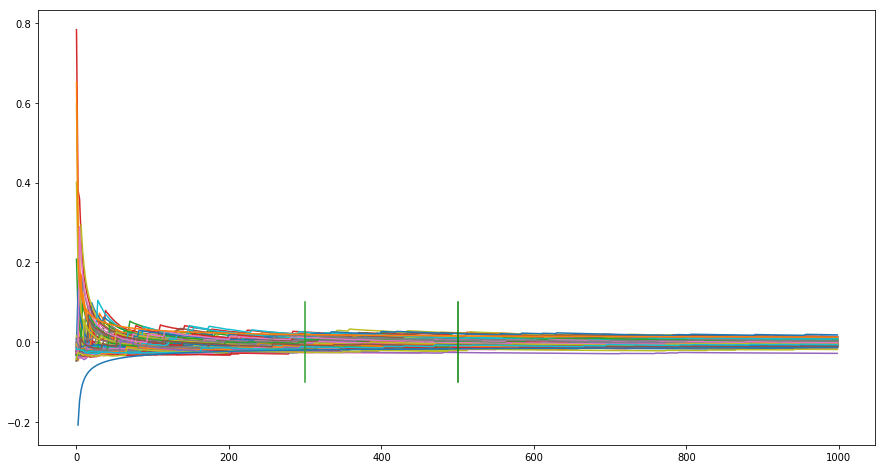

In [35]:
m = 1000
n = 1000
Detect =  np.zeros((100, n//2))
for k in range(100):
    X = np.random.randn(1000).reshape((1000,1))*10
    Y = np.random.randn(10000).reshape((10000,1))*10
    Y[300:500] += 0
    treshold_estimator(X.reshape(1000),lambda x,y: MMDl(x,y,gaussian(0.1)),100, nb_turn = 100)

    
    Liste_mmd = []
    detect = np.zeros(n//2)
    thr = np.zeros(n//2)
    if (_%100==0):
        print(_/repeat*100, '% achevé',end='\r', flush=True)
    kernel = gaussian(0.1)
    MMD =  MMD2l(X,kernel)
    for i in range(0,n//2):
        MMD.update(Y[2*i].reshape((-1,1)),Y[2*i+1].reshape((-1,1)))
        Liste_mmd.append(MMD.MMD[0])
        detect[i] = 1 - MMD.check()
        thr[i] = MMD.treshold()
    T = np.arange(0,n,2)
    plt.plot(T, Liste_mmd)
    Detect[k] = detect
    print(k, end='\r', flush=True)
plt.plot(T,-2*np.sqrt(MMD.factor_v*(1/T+1/MMD.m)))
plt.plot(T,2*np.sqrt(MMD.factor_v*(1/T+1/MMD.m)))
plt.plot([300,300],[0.1,-0.1])
plt.plot([500,500],[0.1,-0.1],'g')

print(f"Proportion de fausse alerte {Detect.mean()*100}%")
print(f"Proportion de trajectoire avec fausse alerte {np.max(Detect,axis=1).mean()*100}%")
print(f"Moyenne des temps avant fausse alerte {np.argmax(Detect[np.max(Detect,axis=1)==1],axis=1).mean() }")

Proportion de fausse alerte 5.3074%
Proportion de trajectoire avec fausse alerte 38.0%
Moyenne des temps avant fausse alerte 145.0


/home/kronert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/home/kronert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide


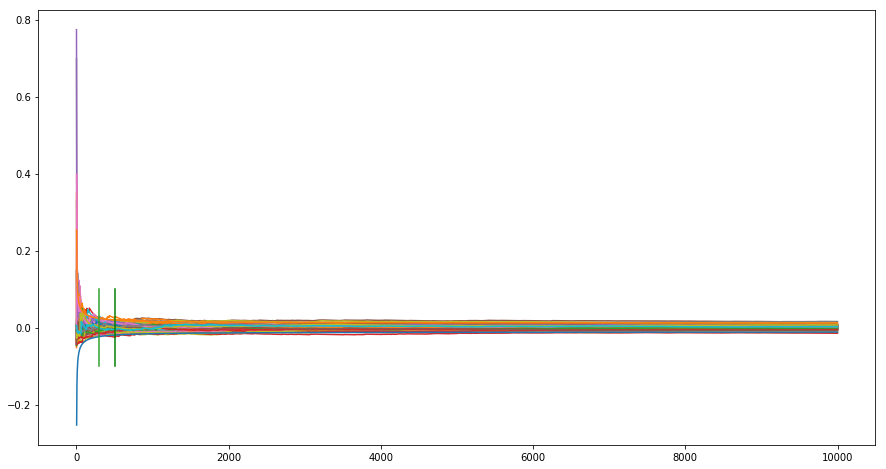

In [36]:
m = 1000
n = 10000
Detect =  np.zeros((100, n//2))
for k in range(100):
    X = np.random.randn(1000).reshape((1000,1))*10
    Y = np.random.randn(10000).reshape((10000,1))*10
    Y[300:500] += 0
    treshold_estimator(X.reshape(1000),lambda x,y: MMDl(x,y,gaussian(0.1)),100, nb_turn = 100)

    
    Liste_mmd = []
    detect = np.zeros(n//2)
    thr = np.zeros(n//2)
    if (_%100==0):
        print(_/repeat*100, '% achevé',end='\r', flush=True)
    kernel = gaussian(0.1)
    MMD =  MMD2l(X,kernel)
    for i in range(0,n//2):
        MMD.update(Y[2*i].reshape((-1,1)),Y[2*i+1].reshape((-1,1)))
        Liste_mmd.append(MMD.MMD[0])
        detect[i] = 1 - MMD.check()
        thr[i] = MMD.treshold()
    T = np.arange(0,n,2)
    plt.plot(T, Liste_mmd)
    Detect[k] = detect
    print(k, end='\r', flush=True)
plt.plot(T,-2*np.sqrt(MMD.factor_v*(1/T+1/MMD.m)))
plt.plot(T,2*np.sqrt(MMD.factor_v*(1/T+1/MMD.m)))
plt.plot([300,300],[0.1,-0.1])
plt.plot([500,500],[0.1,-0.1],'g')

print(f"Proportion de fausse alerte {Detect.mean()*100}%")
print(f"Proportion de trajectoire avec fausse alerte {np.max(Detect,axis=1).mean()*100}%")
print(f"Moyenne des temps avant fausse alerte {np.argmax(Detect[np.max(Detect,axis=1)==1],axis=1).mean() }")

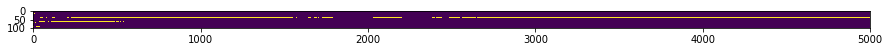

In [37]:
plt.figure(fi)
plt.imshow(Detect)

# H1

In [55]:
def gen_CSP_H1(kernel, law_p, law_q, size=1000):
    L = []
    for i in range(size):
        x = law_p(2)
        x1,x2 = x[0],x[1]
        gen = (kernel(np.r_[x1].reshape((1,1)),np.r_[x2].reshape((1,1))) 
               - est_partial_mean(kernel, law_q, x1) 
               - est_partial_mean(kernel, law_q, x2) )
        L.append(gen)
    return L

In [56]:
def var_H1(kernel, law_p, law_q, alpha, size=1000):
    return np.var(gen_CSP_H1(kernel, law_p, law_q)) + 1/alpha*np.var(gen_CSP_H1(kernel, law_q, law_p))

In [92]:
m = 1000
n = 100
repeat = 1000
Liste_mmd = []
Liste_mmdl = []
for _ in range(repeat):
    if (_%10==0):
        print(_/repeat*100, '% achevé',end='\r',flush=True)
    X = np.random.randn(m).reshape((-1,1))
    Y = np.random.randn(n).reshape((-1,1)) + 1
    kernel = gaussian(10)
    
    MMD =  MMD2l(X,kernel)
    for i in range(0,n//2):
        MMD.update(Y[2*i].reshape((-1,1)),Y[2*i+1].reshape((-1,1)))
    Liste_mmd.append(MMD.MMD[0])
    
    
    Liste_mmdl.append(MMDl(X[:n],Y[:n],kernel))

Text(0.5, 1.0, 'La variance est de 0.18')

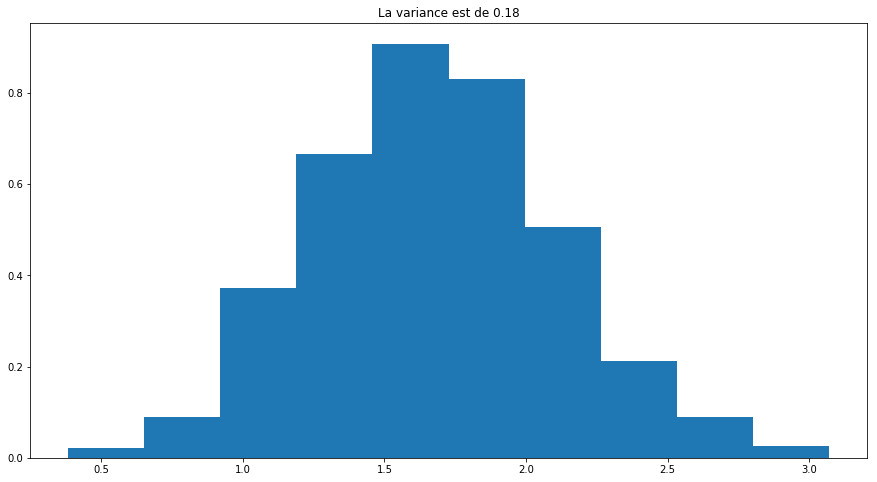

In [93]:
Liste_mmd_array = np.array(Liste_mmd)
Liste_mmd_array = np.sqrt(m/2)*Liste_mmd_array
plt.hist(Liste_mmd_array,density=True);
plt.title(f"La variance est de {np.var(Liste_mmd_array):.2f}")

In [91]:
kernel = gaussian(10)
law_p = lambda size : np.random.randn(size).reshape(-1,1)
law_q = lambda size : np.random.randn(size).reshape(-1,1) + 1
alpha = 1/10
var_H1(kernel, law_p, law_q, alpha, size=10000)

0.18228524406782484

In [62]:
def train_on_data(X,Y,kernel):
    

765.5555555555557

## Références

GRETTON, Arthur, SEJDINOVIC, Dino, STRATHMANN, Heiko, et al. Optimal kernel choice for large-scale two-sample tests. In : Advances in neural information processing systems. 2012. p. 1205-1213

Sriperumbudur, B. K., Gretton, A., Fukumizu, K., Schölkopf, B., & Lanckriet, G. R. (2010). Hilbert space embeddings and metrics on probability measures. Journal of Machine Learning Research, 11(Apr), 1517-1561.